# Mouse round spermatid differentiation

Single-cell RNA-seq uncovers dynamic processes and critical regulators in mouse spermatogenesis, https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE107644

## Import libraries and set working directory

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import pickle
import torch
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Arial']
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import seaborn as sns
import warnings
from sklearn.linear_model import TheilSenRegressor
import scipy
from dcor import distance_correlation
warnings.filterwarnings('ignore')
import omicverse as ov
import sys
sys.path.append('../')

from CauTrigger.utils import set_seed
from CauTrigger.model import CauTrigger

BASE_DIR = '/your/working/directory'
case_path = os.path.join(BASE_DIR, 'CaseSperm/')
data_path = os.path.join(case_path, 'data/')
output_path = os.path.join(case_path, 'output/')
os.makedirs(output_path, exist_ok=True)


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.8, Tutorials: https://omicverse.readthedocs.io/


In [2]:
barcode = pd.read_csv(os.path.join(data_path,'GSE107644_barcode_information.txt'), sep='\t')
stages_all = np.unique([s.split('.')[0] for s in barcode.cell])
stages_RS = [item for item in stages_all if 'RS' in item]

In [3]:
files = os.listdir(data_path)
RS2 = pd.DataFrame()
for stage in ['SpSC11_RS1o2_sc', 'SpSC22_RS1o2_sc', 'SpSC6_RS1o2_sc']:
    tbl = barcode[np.isin([s.split('.')[0] for s in barcode.cell], stage)]
    processed_file = tbl['processed_file'].unique()[0]
    file = [item for item in files if processed_file in item][0]
    count = pd.read_csv(data_path+file, sep='\t', index_col=0)
    count = count.filter(tbl['cell'])
    RS2 = pd.concat([RS2, count], axis=1)
RS4 = pd.DataFrame()
for stage in ['SpSC31_RS3o4_sc']:
    tbl = barcode[np.isin([s.split('.')[0] for s in barcode.cell], stage)]
    processed_file = tbl['processed_file'].unique()[0]
    file = [item for item in files if processed_file in item][0]
    count = pd.read_csv(data_path+file, sep='\t', index_col=0)
    count = count.filter(tbl['cell'])
    RS4 = pd.concat([RS4, count], axis=1)
RS6 = pd.DataFrame()
for stage in ['SpSC32_RS5o6_sc']:
    tbl = barcode[np.isin([s.split('.')[0] for s in barcode.cell], stage)]
    processed_file = tbl['processed_file'].unique()[0]
    file = [item for item in files if processed_file in item][0]
    count = pd.read_csv(data_path+file, sep='\t', index_col=0)
    count = count.filter(tbl['cell'])
    RS6 = pd.concat([RS6, count], axis=1)
RS8 = pd.DataFrame()
for stage in ['SpSC30_RS7o8_sc', 'SpSC9_RS7o8_sc']:
    tbl = barcode[np.isin([s.split('.')[0] for s in barcode.cell], stage)]
    processed_file = tbl['processed_file'].unique()[0]
    file = [item for item in files if processed_file in item][0]
    count = pd.read_csv(data_path+file, sep='\t', index_col=0)
    count = count.filter(tbl['cell'])
    RS8 = pd.concat([RS8, count], axis=1)

In [4]:
adata_2 = sc.AnnData(RS2.T)
adata_4 = sc.AnnData(RS4.T)
adata_6 = sc.AnnData(RS6.T)
adata_8 = sc.AnnData(RS8.T)

In [9]:
color_dict = {'RS2': '#f5ad65', 'RS4': '#91ccae', 'RS6': '#f6c6d6', 'RS8': '#795291'}

         Falling back to preprocessing with `sc.pp.pca` and default params.


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2ba82cd241f0>
Traceback (most recent call last):
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no at

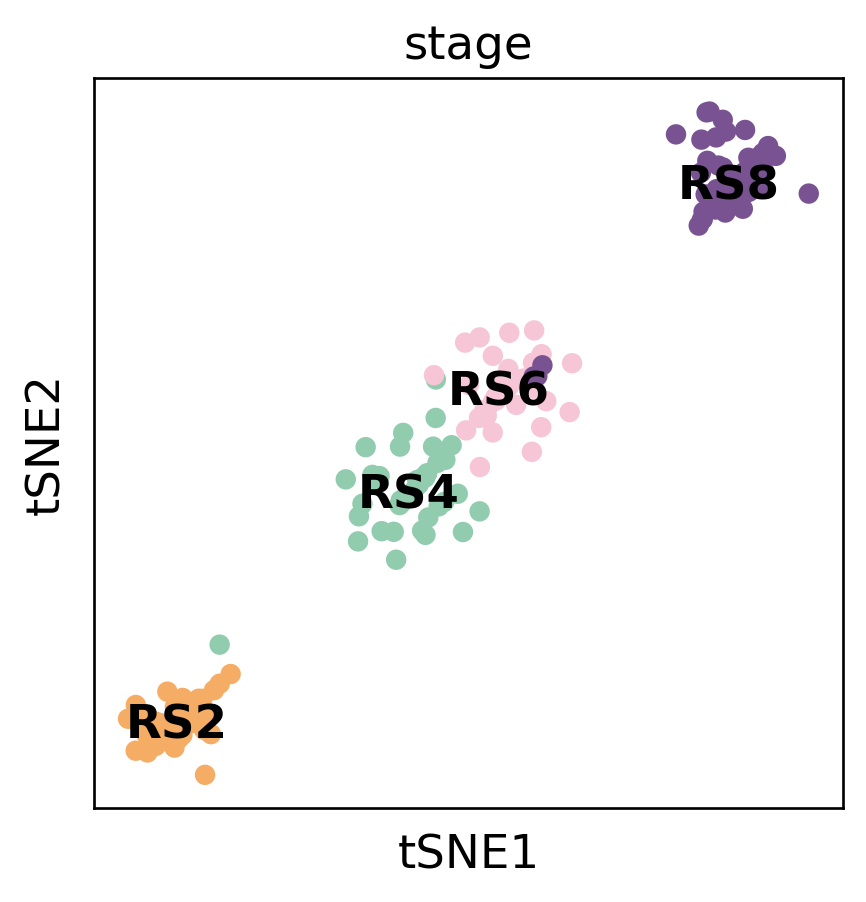

In [10]:
adata_all = sc.concat([adata_2, adata_4, adata_6, adata_8])
adata_all.layers['counts'] = adata_all.X.copy()
adata_all.obs['stage'] = np.repeat(['RS2', 'RS4', 'RS6', 'RS8'], [adata_2.n_obs, adata_4.n_obs, adata_6.n_obs, adata_8.n_obs])
sc.pp.normalize_total(adata_all, target_sum=1e4)
sc.pp.log1p(adata_all)
sc.pp.highly_variable_genes(adata_all, n_top_genes=2000)
sc.pp.neighbors(adata_all)
sc.tl.tsne(adata_all, perplexity=50, learning_rate=500, random_state=42)
sc.pl.tsne(adata_all, color='stage', palette=color_dict, size=150, show=False,legend_loc='on data')
plt.savefig(os.path.join(output_path,'cell_type.pdf'), backend='cairo')

In [ ]:
fig, ax = plt.subplots(figsize=(5,5),constrained_layout=True)
sc.pl.tsne(adata_all, color='stage', show=False, ax=ax, size=150)
ax.set_xscale('linear')
ax.set_yscale('linear')
plt.show()

Please change the cut coordinate according to your tSNE

In [160]:
adata_all = adata_all[-((adata_all.obs['stage'] == 'RS4') & (adata_all.obsm['X_tsne'][:, 1] < -6))]
adata_all = adata_all[-((adata_all.obs['stage'] == 'RS8') & (adata_all.obsm['X_tsne'][:, 1] < 0))]
adata_all = adata_all[-((adata_all.obs['stage'] == 'RS4') & (adata_all.obsm['X_tsne'][:, 1] > -2))]
adata_all = adata_all[-((adata_all.obs['stage'] == 'RS6') & (adata_all.obsm['X_tsne'][:, 1] < -2))]

In [ ]:
fig, ax = plt.subplots(figsize=(5,5),constrained_layout=True)
sc.pl.tsne(adata_all, color='stage', show=False, ax=ax, size=150)
ax.set_xscale('linear')
ax.set_yscale('linear')
plt.show()

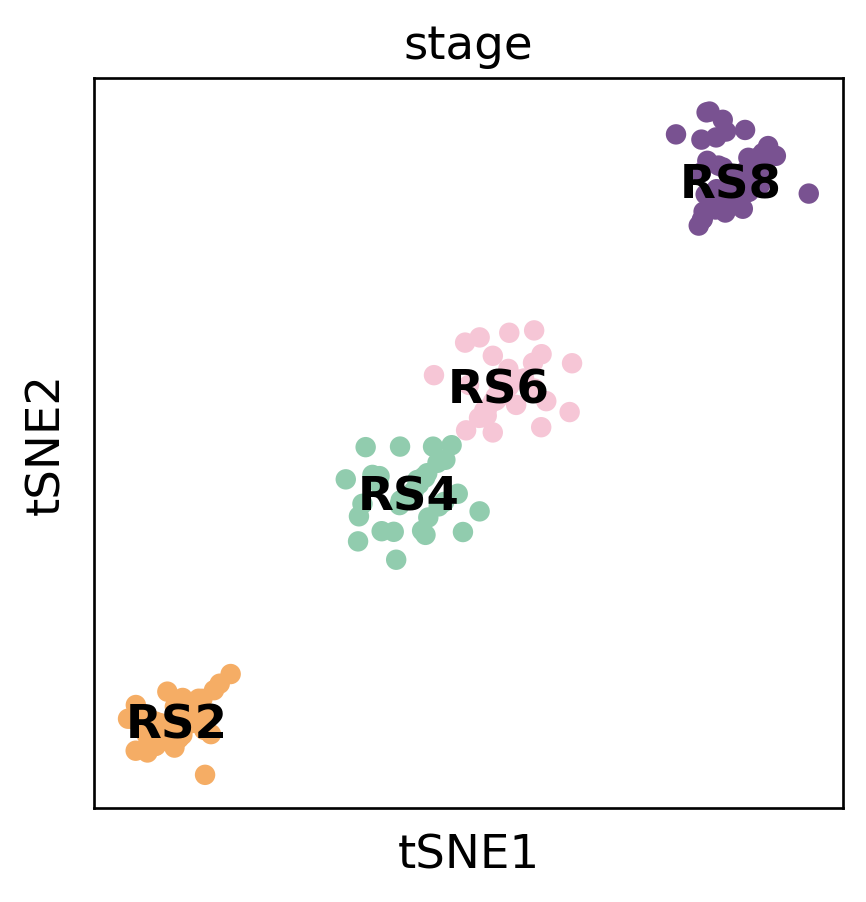

In [162]:
sc.pl.tsne(adata_all, color='stage', palette=color_dict, size=150, show=False,legend_loc='on data')
plt.savefig(os.path.join(output_path,'cell_type_tsne_denoise.pdf'), backend='cairo')

In [163]:
adata_2 = adata_all[adata_all.obs['stage'] == 'RS2']
adata_4 = adata_all[adata_all.obs['stage'] == 'RS4']
adata_6 = adata_all[adata_all.obs['stage'] == 'RS6']
adata_8 = adata_all[adata_all.obs['stage'] == 'RS8']

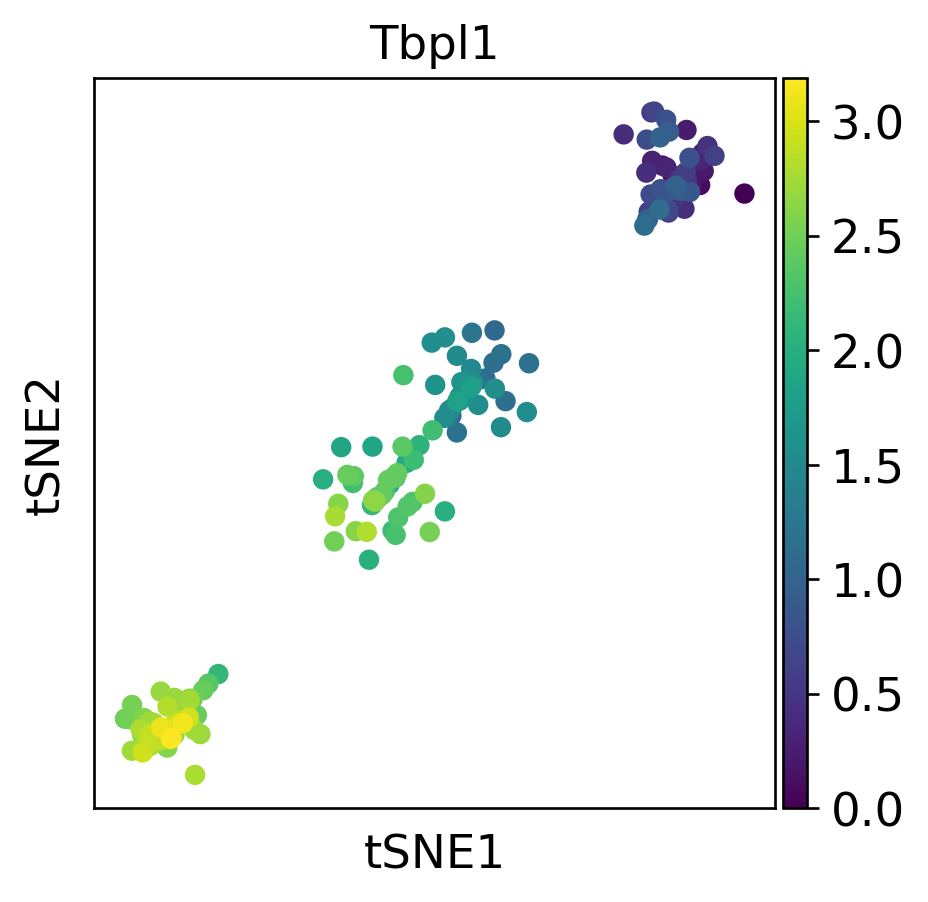

In [164]:
sc.pl.tsne(adata_all, color='Tbpl1', legend_loc='on data', ncols=3, show=False, size=150)
plt.savefig(os.path.join(output_path,'tsne_sperm_Tbpl1.pdf'), bbox_inches='tight', backend='Cairo')

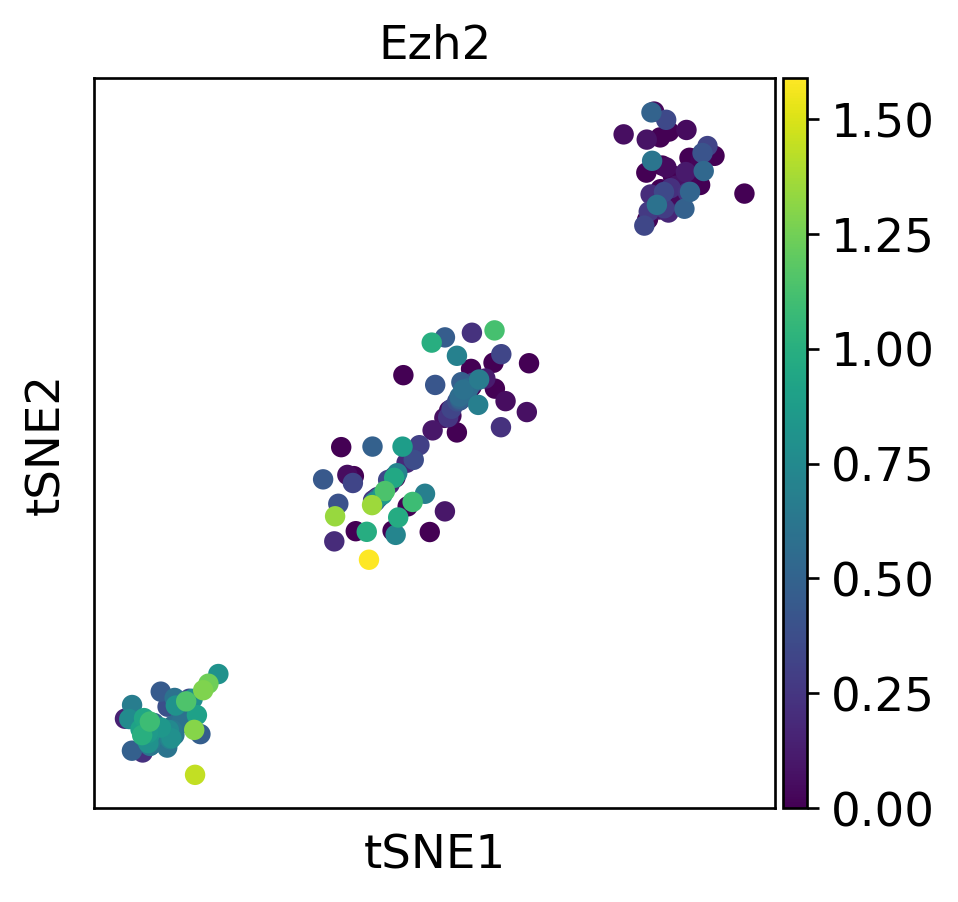

In [165]:
sc.pl.tsne(adata_all, color='Ezh2', legend_loc='on data', ncols=3, show=False, size=150)
plt.savefig(os.path.join(output_path,'tsne_sperm_Ezh2.pdf'), bbox_inches='tight', backend='Cairo')

In [167]:
# 2-4
ctrl_mtx = pd.DataFrame(adata_2.X.copy().T, index=adata_2.var_names, columns=adata_2.obs_names)
treat_mtx = pd.DataFrame(adata_4.X.copy().T, index=adata_4.var_names, columns=adata_4.obs_names)
mtx = pd.concat([ctrl_mtx, treat_mtx], axis=1)
dds = ov.bulk.pyDEG(mtx)
dds.normalize()
treatment_groups=np.array(treat_mtx.columns)
control_groups=np.array(ctrl_mtx.columns)
result=dds.deg_analysis(treatment_groups,control_groups,method='ttest').sort_values(by='abs(log2FC)', ascending=False)
result_deg_24 = result[result.sig == 'sig']

In [168]:
# 4-6
ctrl_mtx = pd.DataFrame(adata_4.X.copy().T, index=adata_4.var_names, columns=adata_4.obs_names)
treat_mtx = pd.DataFrame(adata_6.X.copy().T, index=adata_6.var_names, columns=adata_6.obs_names)
mtx = pd.concat([ctrl_mtx, treat_mtx], axis=1)
dds = ov.bulk.pyDEG(mtx)
dds.normalize()
treatment_groups=np.array(treat_mtx.columns)
control_groups=np.array(ctrl_mtx.columns)
result=dds.deg_analysis(treatment_groups,control_groups,method='ttest').sort_values(by='abs(log2FC)', ascending=False)
result_deg_46 = result[result.sig == 'sig']

In [169]:
# 6-8
ctrl_mtx = pd.DataFrame(adata_6.X.copy().T, index=adata_6.var_names, columns=adata_6.obs_names)
treat_mtx = pd.DataFrame(adata_8.X.copy().T, index=adata_8.var_names, columns=adata_8.obs_names)
mtx = pd.concat([ctrl_mtx, treat_mtx], axis=1)
dds = ov.bulk.pyDEG(mtx)
dds.normalize()
treatment_groups=np.array(treat_mtx.columns)
control_groups=np.array(ctrl_mtx.columns)
result=dds.deg_analysis(treatment_groups,control_groups,method='ttest').sort_values(by='abs(log2FC)', ascending=False)
result_deg_68 = result[result.sig == 'sig']

In [170]:
Trrust = pd.read_table(os.path.join(data_path, 'trrust_rawdata.mouse.tsv'), header=None)
Trrust_TF = Trrust.iloc[:, 0].dropna().unique()
Trrust_nonTF = np.setdiff1d(Trrust.iloc[:, 1].dropna().unique(), Trrust_TF)

In [172]:
# 2-4
outdegree = pd.DataFrame(np.unique(Trrust.iloc[:,0], return_counts=True)).T
DEGtrrust24 = Trrust[np.isin(Trrust.iloc[:,1], result_deg_24.index)]
outdegree_deg = pd.DataFrame(np.unique(DEGtrrust24.iloc[:,0], return_counts=True)).T
outdegree_deg.index = outdegree_deg.iloc[:,0]
outdegree1 = outdegree[np.isin(outdegree.iloc[:,0], outdegree_deg.iloc[:,0])]
outdegree1.index = outdegree1.iloc[:,0]
deg_per = pd.DataFrame({'percent':outdegree_deg.iloc[:,1] / outdegree1.iloc[:,1]})
deg_per.index = outdegree_deg.iloc[:,0]
all_df = pd.concat([outdegree1, outdegree_deg, deg_per], axis=1)
all_df24 = all_df.sort_values(by='percent', ascending=False)

In [174]:
# 4-6
outdegree = pd.DataFrame(np.unique(Trrust.iloc[:,0], return_counts=True)).T
DEGtrrust46 = Trrust[np.isin(Trrust.iloc[:,1], result_deg_46.index)]
outdegree_deg = pd.DataFrame(np.unique(DEGtrrust46.iloc[:,0], return_counts=True)).T
outdegree_deg.index = outdegree_deg.iloc[:,0]
outdegree1 = outdegree[np.isin(outdegree.iloc[:,0], outdegree_deg.iloc[:,0])]
outdegree1.index = outdegree1.iloc[:,0]
deg_per = pd.DataFrame({'percent':outdegree_deg.iloc[:,1] / outdegree1.iloc[:,1]})
deg_per.index = outdegree_deg.iloc[:,0]
all_df = pd.concat([outdegree1, outdegree_deg, deg_per], axis=1)
all_df46 = all_df.sort_values(by='percent', ascending=False)

In [175]:
# 6-8
outdegree = pd.DataFrame(np.unique(Trrust.iloc[:,0], return_counts=True)).T
DEGtrrust68 = Trrust[np.isin(Trrust.iloc[:,1], result_deg_68.index)]
outdegree_deg = pd.DataFrame(np.unique(DEGtrrust68.iloc[:,0], return_counts=True)).T
outdegree_deg.index = outdegree_deg.iloc[:,0]
outdegree1 = outdegree[np.isin(outdegree.iloc[:,0], outdegree_deg.iloc[:,0])]
outdegree1.index = outdegree1.iloc[:,0]
deg_per = pd.DataFrame({'percent':outdegree_deg.iloc[:,1] / outdegree1.iloc[:,1]})
deg_per.index = outdegree_deg.iloc[:,0]
all_df = pd.concat([outdegree1, outdegree_deg, deg_per], axis=1)
all_df68 = all_df.sort_values(by='percent', ascending=False)

In [176]:
adata_all_TF = adata_all[:, np.intersect1d(adata_all.var_names, Trrust_TF)]
adata_all_down = adata_all[:, np.intersect1d(adata_all.var_names, Trrust_nonTF)]

In [ ]:
init_weight_df = pd.DataFrame({'weight':0.5}, index=adata_all_TF.var_names)
all_df2 = all_df24.copy()
all_df2['percent'] = 1
for i in all_df2.index:
    init_weight_df.loc[i,:] = all_df2.loc[i,'percent']
state_pair = ('RS2', 'RS4')
paul_for_cautrigger_state1 = adata_all_TF[adata_all_TF.obs.stage == state_pair[0]].copy()
paul_for_cautrigger_state1.obsm['X_down'] = adata_all_down[adata_all_down.obs.stage == state_pair[0]].X.copy()
paul_for_cautrigger_state1.obs['labels'] = np.repeat(0, paul_for_cautrigger_state1.n_obs)
paul_for_cautrigger_state2 = adata_all_TF[adata_all_TF.obs.stage == state_pair[1]].copy()
paul_for_cautrigger_state2.obsm['X_down'] = adata_all_down[adata_all_down.obs.stage == state_pair[1]].X.copy()
paul_for_cautrigger_state2.obs['labels'] = np.repeat(1, paul_for_cautrigger_state2.n_obs)
adata24 = sc.concat([paul_for_cautrigger_state1, paul_for_cautrigger_state2])
set_seed(42)
model24 = CauTrigger(
        adata24,
        n_causal=2,
        n_latent=10,
        n_hidden=128,
        n_layers_encoder=0,
        n_layers_decoder=0,
        n_layers_dpd=0,
        dropout_rate_encoder=0.1,
        dropout_rate_decoder=0.1,
        dropout_rate_dpd=0.1,
        use_batch_norm='none',
        use_batch_norm_dpd=True,
        decoder_linear=True,
        dpd_linear=False,
        init_weight=init_weight_df.weight,
        init_thresh=0.0,
        update_down_weight=False,
        attention=False,
        att_mean=False,
        direct_causal=False,
    )
weight_scheme = {'stage1': [0.1, 2.0, 2.0, 1, 0.2, 0.2, 0.0, 0.1, 0.1],
                         'stage2': [0.4, 1.0, 1.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.1],
                         'stage3': [0.8, 0.5, 0.5, 0.5, 0.0, 0.1, 2.0, 0.1, 0.1],
                         'stage4': [1, 0.2, 0.2, 0.5, 0.0, 0.0, 2.0, 2.0, 2.0]}
model24.train(max_epochs=200, im_factor=1, weight_scheme=weight_scheme)

In [ ]:
init_weight_df = pd.DataFrame({'weight':0.5}, index=adata_all_TF.var_names)
all_df2 = all_df46.copy()
all_df2['percent'] = 1
for i in all_df2.index:
    init_weight_df.loc[i,:] = all_df2.loc[i,'percent']
state_pair = ('RS4', 'RS6')
paul_for_cautrigger_state1 = adata_all_TF[adata_all_TF.obs.stage == state_pair[0]].copy()
paul_for_cautrigger_state1.obsm['X_down'] = adata_all_down[adata_all_down.obs.stage == state_pair[0]].X.copy()
paul_for_cautrigger_state1.obs['labels'] = np.repeat(0, paul_for_cautrigger_state1.n_obs)
paul_for_cautrigger_state2 = adata_all_TF[adata_all_TF.obs.stage == state_pair[1]].copy()
paul_for_cautrigger_state2.obsm['X_down'] = adata_all_down[adata_all_down.obs.stage == state_pair[1]].X.copy()
paul_for_cautrigger_state2.obs['labels'] = np.repeat(1, paul_for_cautrigger_state2.n_obs)
adata46 = sc.concat([paul_for_cautrigger_state1, paul_for_cautrigger_state2])
set_seed(42)
model46 = CauTrigger(
        adata46,
        n_causal=2,
        n_latent=10,
        n_hidden=128,
        n_layers_encoder=0,
        n_layers_decoder=0,
        n_layers_dpd=0,
        dropout_rate_encoder=0.1,
        dropout_rate_decoder=0.1,
        dropout_rate_dpd=0.1,
        use_batch_norm='none',
        use_batch_norm_dpd=True,
        decoder_linear=True,
        dpd_linear=False,
        init_weight=init_weight_df.weight,
        init_thresh=0.0,
        update_down_weight=False,
        attention=False,
        att_mean=False,
        direct_causal=False,
    )
weight_scheme = {'stage1': [0.1, 2.0, 2.0, 1, 0.2, 0.2, 0.0, 0.1, 0.1],
                         'stage2': [0.4, 1.0, 1.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.1],
                         'stage3': [0.8, 0.5, 0.5, 0.5, 0.0, 0.1, 2.0, 0.1, 0.1],
                         'stage4': [1, 0.2, 0.2, 0.5, 0.0, 0.0, 2.0, 2.0, 2.0]}
model46.train(max_epochs=200, im_factor=1, weight_scheme=weight_scheme)

In [ ]:
init_weight_df = pd.DataFrame({'weight':0.5}, index=adata_all_TF.var_names)
all_df2 = all_df68.copy()
all_df2['percent'] = 1
for i in all_df2.index:
    init_weight_df.loc[i,:] = all_df2.loc[i,'percent']
state_pair = ('RS6', 'RS8')
paul_for_cautrigger_state1 = adata_all_TF[adata_all_TF.obs.stage == state_pair[0]].copy()
paul_for_cautrigger_state1.obsm['X_down'] = adata_all_down[adata_all_down.obs.stage == state_pair[0]].X.copy()
paul_for_cautrigger_state1.obs['labels'] = np.repeat(0, paul_for_cautrigger_state1.n_obs)
paul_for_cautrigger_state2 = adata_all_TF[adata_all_TF.obs.stage == state_pair[1]].copy()
paul_for_cautrigger_state2.obsm['X_down'] = adata_all_down[adata_all_down.obs.stage == state_pair[1]].X.copy()
paul_for_cautrigger_state2.obs['labels'] = np.repeat(1, paul_for_cautrigger_state2.n_obs)
adata68 = sc.concat([paul_for_cautrigger_state1, paul_for_cautrigger_state2])
set_seed(42)
model68 = CauTrigger(
        adata68,
        n_causal=2,
        n_latent=10,
        n_hidden=128,
        n_layers_encoder=0,
        n_layers_decoder=0,
        n_layers_dpd=0,
        dropout_rate_encoder=0.1,
        dropout_rate_decoder=0.1,
        dropout_rate_dpd=0.1,
        use_batch_norm='none',
        use_batch_norm_dpd=True,
        decoder_linear=True,
        dpd_linear=False,
        init_weight=init_weight_df.weight,
        init_thresh=0.0,
        update_down_weight=False,
        attention=False,
        att_mean=False,
        direct_causal=False,
    )
weight_scheme = {'stage1': [0.1, 2.0, 2.0, 1, 0.2, 0.2, 0.0, 0.1, 0.1],
                         'stage2': [0.4, 1.0, 1.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.1],
                         'stage3': [0.8, 0.5, 0.5, 0.5, 0.0, 0.1, 2.0, 0.1, 0.1],
                         'stage4': [1, 0.2, 0.2, 0.5, 0.0, 0.0, 2.0, 2.0, 2.0]}
model68.train(max_epochs=200, im_factor=1, weight_scheme=weight_scheme)

In [180]:
grad_df_full_logit24 = pd.DataFrame(model24.get_up_feature_weights(normalize=True, method='Grad', grad_source='logit', sort_by_weight=False)[1], columns=adata_all_TF.var.copy().index)
grad_df_full_logit24['labels'] = np.array(adata24.obs['labels'])
grad_df_full_logit24 = grad_df_full_logit24.groupby('labels').mean()

In [181]:
grad_df_full_logit46 = pd.DataFrame(model46.get_up_feature_weights(normalize=True, method='Grad', grad_source='logit', sort_by_weight=False)[1], columns=adata_all_TF.var.copy().index)
grad_df_full_logit46['labels'] = np.array(adata46.obs['labels'])
grad_df_full_logit46 = grad_df_full_logit46.groupby('labels').mean()

In [182]:
grad_df_full_logit68 = pd.DataFrame(model68.get_up_feature_weights(normalize=True, method='Grad', grad_source='logit', sort_by_weight=False)[1], columns=adata_all_TF.var.copy().index)
grad_df_full_logit68['labels'] = np.array(adata68.obs['labels'])
grad_df_full_logit68 = grad_df_full_logit68.groupby('labels').mean()

In [183]:
grad_df_full_logit24_binary = grad_df_full_logit24.applymap(lambda x: 'Up' if x > 0 else ('Down' if x < 0 else x))
grad_df_full_logit24_binary.loc[1,:].to_csv(output_path+'grad_df_full_logit24_binary.csv')
grad_df_full_logit46_binary = grad_df_full_logit46.applymap(lambda x: 'Up' if x > 0 else ('Down' if x < 0 else x))
grad_df_full_logit46_binary.loc[1,:].to_csv(output_path+'grad_df_full_logit46_binary.csv')
grad_df_full_logit68_binary = grad_df_full_logit68.applymap(lambda x: 'Up' if x > 0 else ('Down' if x < 0 else x))
grad_df_full_logit68_binary.loc[1,:].to_csv(output_path+'grad_df_full_logit68_binary.csv')

In [281]:
TF_all_rank_df24 = pd.DataFrame(model24.get_up_feature_weights(normalize=False, method="Model", sort_by_weight=True)[0])
TF_all_rank_df24.to_csv(output_path+'TF_all_rank_df_24.csv')
DEGtrrust24.to_csv(output_path+'DEGtrrust24.csv')
TF_all_rank_df46 = pd.DataFrame(model46.get_up_feature_weights(normalize=False, method="Model", sort_by_weight=True)[0])
TF_all_rank_df46.to_csv(output_path+'TF_all_rank_df_46.csv')
DEGtrrust46.to_csv(output_path+'DEGtrrust46.csv')
TF_all_rank_df68 = pd.DataFrame(model68.get_up_feature_weights(normalize=False, method="Model", sort_by_weight=True)[0])
TF_all_rank_df68.to_csv(output_path+'TF_all_rank_df_68.csv')
DEGtrrust68.to_csv(output_path+'DEGtrrust68.csv')

## Draw the tSNE after perturbation

In [187]:
state_obs = 'stage'
pertA = 'Tbpl1'
model = model24
state_pair = ('RS2', 'RS4')
adata_pertA = adata24.copy()
pert_cell_idx = np.where(adata_pertA.obs[state_obs] == state_pair[0])[0]
adata_pertA = adata_pertA[pert_cell_idx, :]
adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)] = 0
model.eval()
with torch.no_grad():
    model_output_pertA = model.get_model_output(adata_pertA)
adata_pertA.X = model_output_pertA['x_up_rec1']
adata2 = adata_pertA
model = model46
state_pair = ('RS4', 'RS6')
adata_pertA = adata46.copy()
pert_cell_idx = np.where(adata_pertA.obs[state_obs] == state_pair[0])[0]
adata_pertA = adata_pertA[pert_cell_idx, :]
adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)] = 0
model.eval()
with torch.no_grad():
    model_output_pertA = model.get_model_output(adata_pertA)
adata_pertA.X = model_output_pertA['x_up_rec1']
adata4 = adata_pertA
model = model68
state_pair = ('RS6', 'RS8')
adata_pertA = adata68.copy()
pert_cell_idx = np.where(adata_pertA.obs[state_obs] == state_pair[0])[0]
adata_pertA = adata_pertA[pert_cell_idx, :]
adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)] = 0
model.eval()
with torch.no_grad():
    model_output_pertA = model.get_model_output(adata_pertA)
adata_pertA.X = model_output_pertA['x_up_rec1']
adata6 = adata_pertA
adata_all_changed = sc.concat([adata2, adata4, adata6, adata_all_TF[adata_all_TF.obs['stage'] == 'RS8']])

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


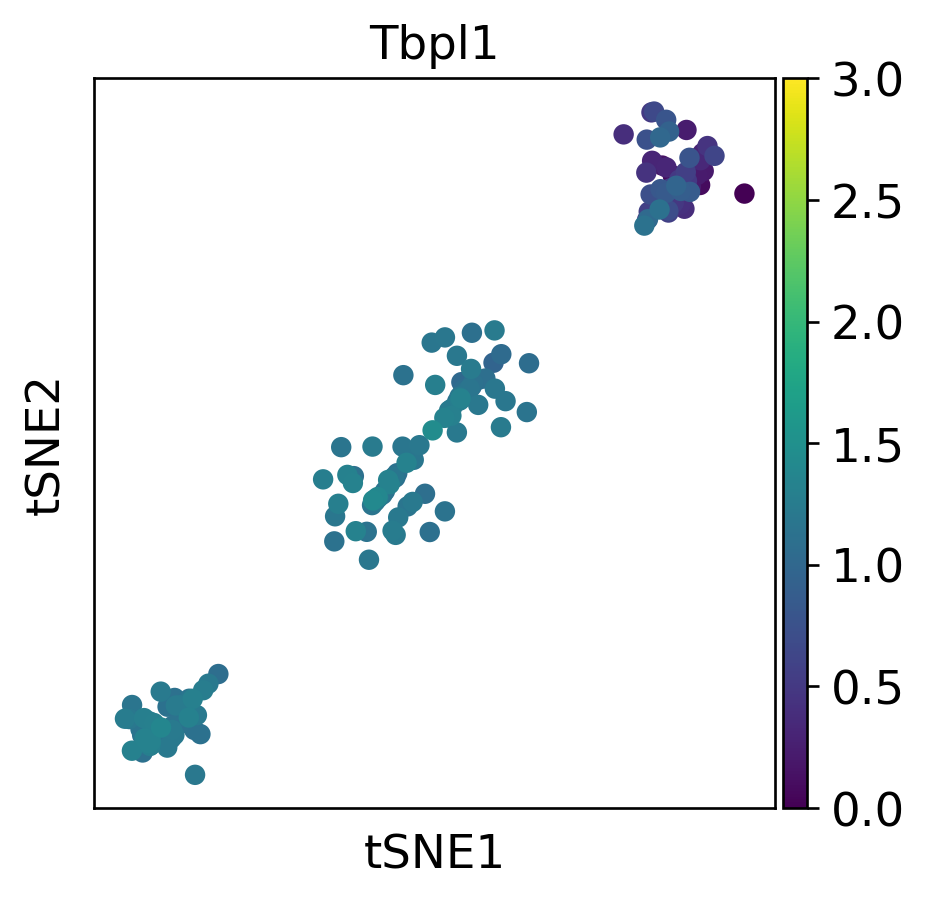

In [188]:
sc.pl.tsne(adata_all_changed, color='Tbpl1', legend_loc='on data', ncols=3, show=False, size=150, vmin=0, vmax=3)
plt.savefig(os.path.join(output_path,'tsne_sperm_Tbpl1_rec.pdf'), bbox_inches='tight', backend='Cairo')

In [189]:
state_obs = 'stage'
pertA = 'Ezh2'
model = model24
state_pair = ('RS2', 'RS4')
adata_pertA = adata24.copy()
pert_cell_idx = np.where(adata_pertA.obs[state_obs] == state_pair[0])[0]
adata_pertA = adata_pertA[pert_cell_idx, :]
adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)] = 0
model.eval()
with torch.no_grad():
    model_output_pertA = model.get_model_output(adata_pertA)
adata_pertA.X = model_output_pertA['x_up_rec1']
adata2 = adata_pertA
model = model46
state_pair = ('RS4', 'RS6')
adata_pertA = adata46.copy()
pert_cell_idx = np.where(adata_pertA.obs[state_obs] == state_pair[0])[0]
adata_pertA = adata_pertA[pert_cell_idx, :]
adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)] = 0
model.eval()
with torch.no_grad():
    model_output_pertA = model.get_model_output(adata_pertA)
adata_pertA.X = model_output_pertA['x_up_rec1']
adata4 = adata_pertA
model = model68
state_pair = ('RS6', 'RS8')
adata_pertA = adata68.copy()
pert_cell_idx = np.where(adata_pertA.obs[state_obs] == state_pair[0])[0]
adata_pertA = adata_pertA[pert_cell_idx, :]
adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)] = 0
model.eval()
with torch.no_grad():
    model_output_pertA = model.get_model_output(adata_pertA)
adata_pertA.X = model_output_pertA['x_up_rec1']
adata6 = adata_pertA
adata_all_changed = sc.concat([adata2, adata4, adata6, adata_all_TF[adata_all_TF.obs['stage'] == 'RS8']])

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


<AxesSubplot: title={'center': 'Ezh2'}, xlabel='tSNE1', ylabel='tSNE2'>

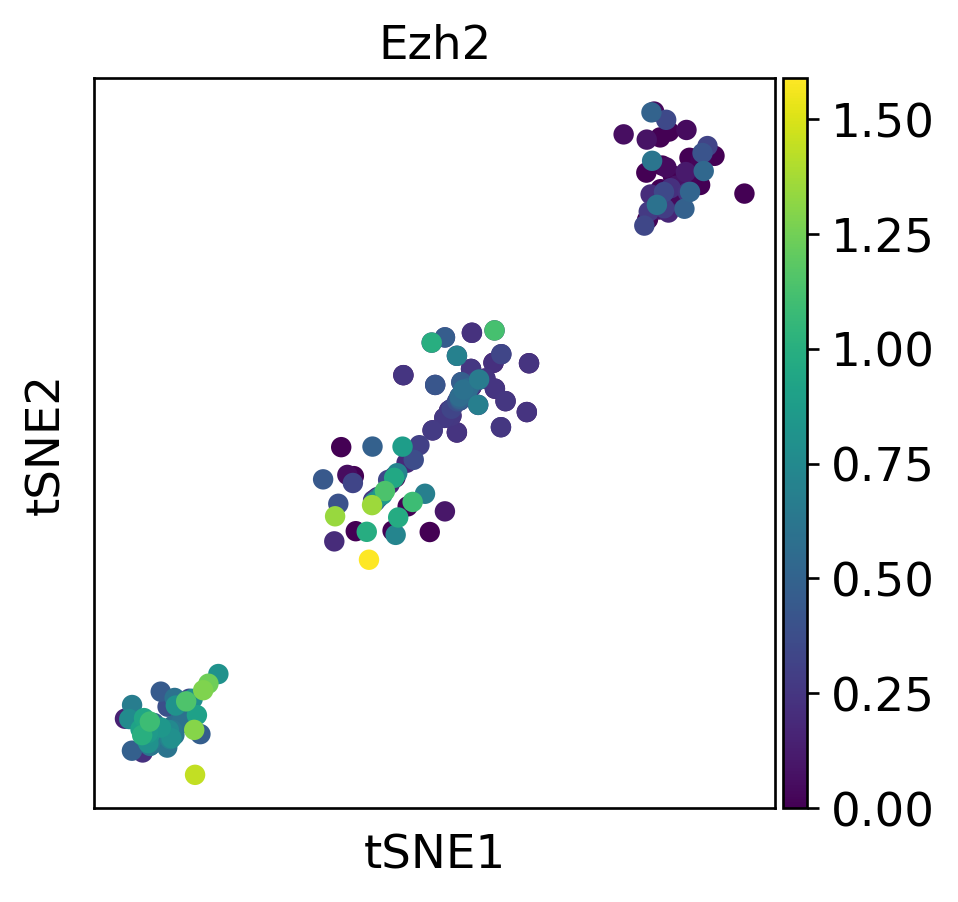

In [313]:
sc.pl.tsne(adata_all_changed, color='Ezh2', legend_loc='on data', ncols=3, show=False, size=150, vmin=0, vmax=1.5)
plt.savefig(os.path.join(output_path,'tsne_sperm_Ezh2_rec.pdf'), bbox_inches='tight', backend='Cairo')

## Comparison of change of targets and nontargets

In [392]:
state_obs = 'stage'
pertA = 'Tbpl1'
model = model24
state_pair = ('RS2', 'RS4')
adata_pertA = adata24.copy()
pert_cell_idx = np.where(adata_pertA.obs[state_obs] == state_pair[0])[0]
adata_pertA = adata_pertA[pert_cell_idx, :]
adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)] = 0
model.eval()
with torch.no_grad():
    model_output_pertA = model.get_model_output(adata_pertA)
adata_pertA.X = model_output_pertA['x_up_rec1']
adata_pertA.obsm['X_down_new'] = model_output_pertA['x_down_rec_alpha']
adata2 = adata_pertA
model = model46
state_pair = ('RS4', 'RS6')
adata_pertA = adata46.copy()
pert_cell_idx = np.where(adata_pertA.obs[state_obs] == state_pair[0])[0]
adata_pertA = adata_pertA[pert_cell_idx, :]
adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)] = 0
model.eval()
with torch.no_grad():
    model_output_pertA = model.get_model_output(adata_pertA)
adata_pertA.X = model_output_pertA['x_up_rec1']
adata_pertA.obsm['X_down_new'] = model_output_pertA['x_down_rec_alpha']
adata4 = adata_pertA
model = model68
state_pair = ('RS6', 'RS8')
adata_pertA = adata68.copy()
pert_cell_idx = np.where(adata_pertA.obs[state_obs] == state_pair[0])[0]
adata_pertA = adata_pertA[pert_cell_idx, :]
adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)] = 0
model.eval()
with torch.no_grad():
    model_output_pertA = model.get_model_output(adata_pertA)
adata_pertA.X = model_output_pertA['x_up_rec1']
adata_pertA.obsm['X_down_new'] = model_output_pertA['x_down_rec_alpha']
adata6 = adata_pertA
targetsA = np.unique(RGMs[pertA][1])
nontargetsA = np.setdiff1d(adata_all_down.var_names, np.unique(RGMs[pertA][1]))
targetsA_delta = adata2.obsm['X_down'][:,np.isin(adata_all_down.var_names, targetsA)] - adata2.obsm['X_down_new'][:,np.isin(adata_all_down.var_names, targetsA)]
nontargetsA_delta = adata2.obsm['X_down'][:,np.isin(adata_all_down.var_names, nontargetsA)] - adata2.obsm['X_down_new'][:,np.isin(adata_all_down.var_names, nontargetsA)]
targetsA_mean2 = abs(np.mean(targetsA_delta, axis=1))
nontargetsA_mean2 = abs(np.mean(nontargetsA_delta, axis=1))
targetsA = np.unique(RGMs[pertA][1])
nontargetsA = np.setdiff1d(adata_all_down.var_names, np.unique(RGMs[pertA][1]))
targetsA_delta = adata4.obsm['X_down'][:,np.isin(adata_all_down.var_names, targetsA)] - adata4.obsm['X_down_new'][:,np.isin(adata_all_down.var_names, targetsA)]
nontargetsA_delta = adata4.obsm['X_down'][:,np.isin(adata_all_down.var_names, nontargetsA)] - adata4.obsm['X_down_new'][:,np.isin(adata_all_down.var_names, nontargetsA)]
targetsA_mean4 = abs(np.mean(targetsA_delta, axis=1))
nontargetsA_mean4 = abs(np.mean(nontargetsA_delta, axis=1))
targetsA = np.unique(RGMs[pertA][1])
nontargetsA = np.setdiff1d(adata_all_down.var_names, np.unique(RGMs[pertA][1]))
targetsA_delta = adata6.obsm['X_down'][:,np.isin(adata_all_down.var_names, targetsA)] - adata6.obsm['X_down_new'][:,np.isin(adata_all_down.var_names, targetsA)]
nontargetsA_delta = adata6.obsm['X_down'][:,np.isin(adata_all_down.var_names, nontargetsA)] - adata6.obsm['X_down_new'][:,np.isin(adata_all_down.var_names, nontargetsA)]
targetsA_mean6 = abs(np.mean(targetsA_delta, axis=1))
nontargetsA_mean6 = abs(np.mean(nontargetsA_delta, axis=1))

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


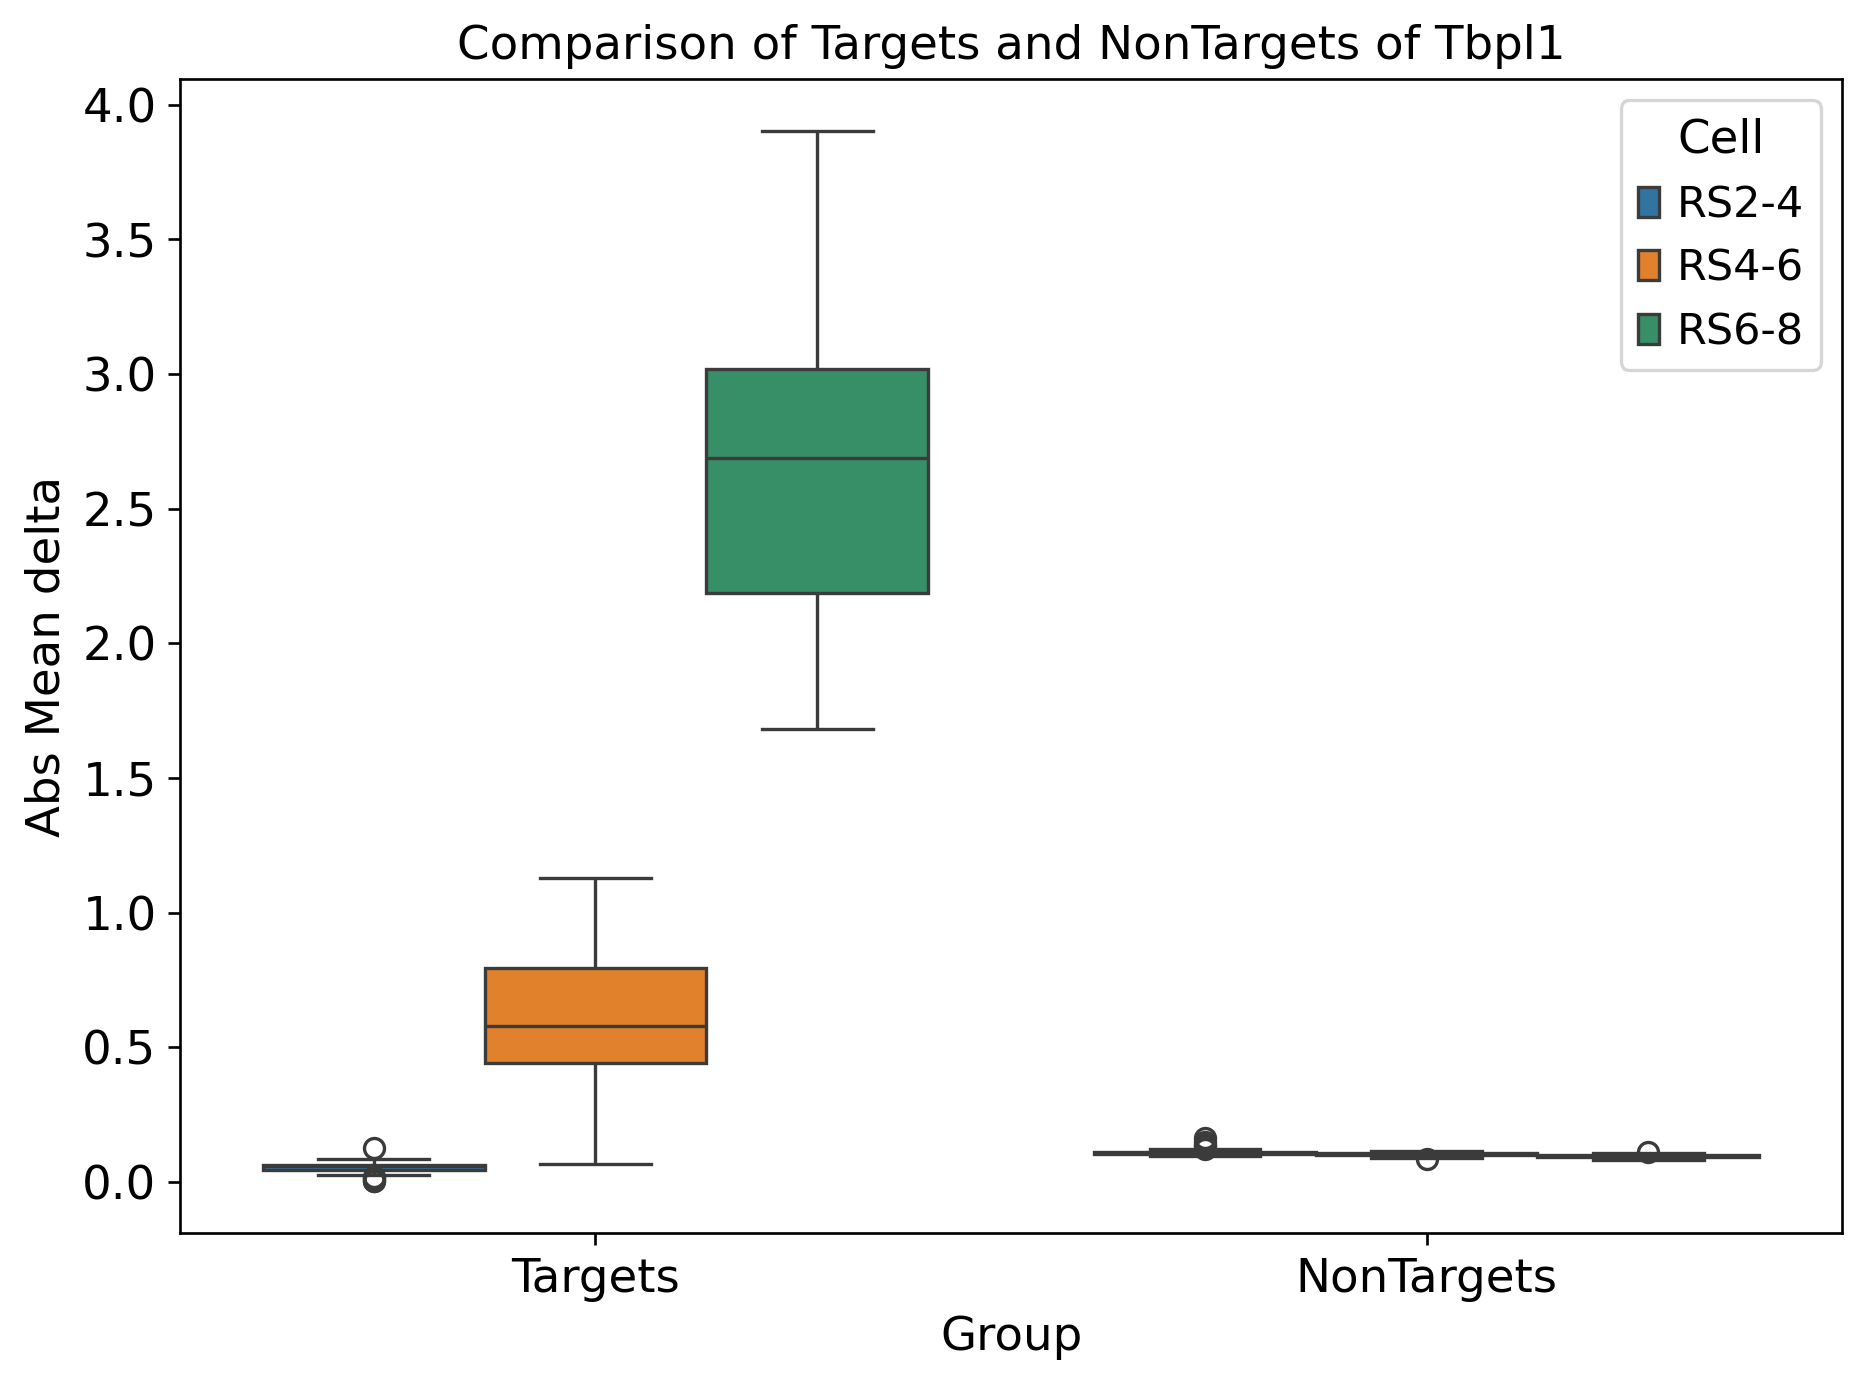

In [393]:
df = pd.DataFrame({
    'Values': np.concatenate([targetsA_mean2, nontargetsA_mean2, targetsA_mean4, nontargetsA_mean4, targetsA_mean6, nontargetsA_mean6]),
    'Group': ['Targets'] * len(targetsA_mean2) + ['NonTargets'] * len(nontargetsA_mean2) + ['Targets'] * len(targetsA_mean4) + ['NonTargets'] * len(nontargetsA_mean4) + ['Targets'] * len(targetsA_mean6) + ['NonTargets'] * len(nontargetsA_mean6),
    'Cell' : ['RS2-4'] * (len(targetsA_mean2)+len(nontargetsA_mean2)) + ['RS4-6'] * (len(targetsA_mean4)+len(nontargetsA_mean4)) + ['RS6-8'] * (len(targetsA_mean6)+len(nontargetsA_mean6))
})
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Group', y='Values', hue='Cell', data=df)
plt.ylabel("Abs Mean delta")
plt.title(f"Comparison of Targets and NonTargets of {pertA}")
plt.grid(False, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_path, f'Comparison of Targets and NonTargets of {pertA}.pdf'))
plt.show()

## Plot vector field map

In [192]:
def plot_vector_field(adata,state_pair=None,KO_Gene=None,state_obs=None,embedding_name=None,method=None,
                      sampled_fraction=1, min_mass=0.008,scale=0.1, save_dir=None,smooth=0.8,n_grid=40,
                     draw_single=None,n_suggestion=12,show=False,dot_size=None,run_suggest_mass_thresholds=False,direction=None,n_neighbors=None,):
    from scipy import sparse
    from sklearn.neighbors import NearestNeighbors
    from velocyto.estimation import colDeltaCorpartial
    from scipy.stats import norm as normal
    import math

    def replace_with_CauTrigger(adata, corrcoef, state_pair=state_pair, state_obs=state_obs, method=method):
        corrcoef_ = corrcoef.copy()
        if method == 'prob':
            probs = adata.obs['probs'].copy()
            probs_pert = adata.obs['probs_pert'].copy()
        if method == 'logits':
            probs = adata.obs['logits'].copy()
            probs_pert = adata.obs['logits_pert'].copy()
        neigh_ixs = adata.uns['neigh_ixs'].copy()
        target_index = np.where((adata.obs[state_obs] == state_pair[0]) | (adata.obs[state_obs] == state_pair[1]))[0]
        nontarget_neighbor_index = np.setdiff1d(np.unique(neigh_ixs[target_index, :].flatten()), target_index)
        nonneighbor_index = np.setdiff1d(np.setdiff1d(np.arange(probs.shape[0]), target_index), nontarget_neighbor_index)
        for i in target_index:
            cols = np.setdiff1d(np.union1d(target_index, nontarget_neighbor_index), i)
            cor =  - abs(probs_pert[i] - probs[cols])
            corrcoef_[i, cols] = cor
        corrcoef_[np.union1d(nontarget_neighbor_index, nonneighbor_index), :] = 0
        return corrcoef_

    def estimate_transition_prob(adata, state_pair=state_pair,state_obs=state_obs, embedding_name=embedding_name, n_neighbors=None,
                                 sampled_fraction=sampled_fraction, sigma_corr=0.005, replace_prob=None,draw_single=None):
        sampling_probs = (0.5, 0.1)
        X = adata.layers["imputed_count"].transpose().copy()
        delta_X = adata.layers["delta_X"].transpose().copy()
        embedding = adata.obsm[embedding_name].copy()
        if n_neighbors is None:
            n_neighbors = int(adata.shape[0] / 5)
        nn = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=4)
        nn.fit(embedding)
        embedding_knn = nn.kneighbors_graph(mode="connectivity")
        neigh_ixs = embedding_knn.indices.reshape((-1, n_neighbors + 1))
        p = np.linspace(sampling_probs[0], sampling_probs[1], neigh_ixs.shape[1])
        p = p / p.sum()
        sampling_ixs = np.stack([np.random.choice(neigh_ixs.shape[1],
                                                  size=(int(sampled_fraction * (n_neighbors + 1)),),
                                                  replace=False,
                                                  p=p) for i in range(neigh_ixs.shape[0])], 0)
        neigh_ixs = neigh_ixs[np.arange(neigh_ixs.shape[0])[:, None], sampling_ixs]
        nonzero = neigh_ixs.shape[0] * neigh_ixs.shape[1]
        embedding_knn = sparse.csr_matrix((np.ones(nonzero),
                                           neigh_ixs.ravel(),
                                           np.arange(0, nonzero + 1, neigh_ixs.shape[1])),
                                          shape=(neigh_ixs.shape[0],
                                                 neigh_ixs.shape[0]))
        adata.uns['neigh_ixs'] = neigh_ixs.copy()
        corrcoef = colDeltaCorpartial(X, delta_X, neigh_ixs)
        if replace_prob == 'prob':
            corrcoef = replace_with_CauTrigger(adata, corrcoef, state_pair=state_pair,state_obs=state_obs, method='prob')
        if replace_prob == 'logits':
            corrcoef = replace_with_CauTrigger(adata, corrcoef,state_pair=state_pair,state_obs=state_obs, method='logits')
        if np.any(np.isnan(corrcoef)):
            corrcoef[np.isnan(corrcoef)] = 1
        transition_prob = np.exp(corrcoef / sigma_corr) * embedding_knn.A
        transition_prob /= transition_prob.sum(1)[:, None]
        adata.obsm['embedding_knn'] = embedding_knn.copy()
        adata.obsp['transition_prob'] = transition_prob.copy()

    def calculate_embedding_shift(adata, embedding_name=embedding_name):
        transition_prob = adata.obsp['transition_prob'].copy()
        embedding = adata.obsm[embedding_name].copy()
        embedding_knn = adata.obsm['embedding_knn'].copy()
        unitary_vectors = embedding.T[:, None, :] - embedding.T[:, :, None]
        with np.errstate(divide='ignore', invalid='ignore'):
            unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)
            np.fill_diagonal(unitary_vectors[0, ...], 0)
            np.fill_diagonal(unitary_vectors[1, ...], 0)
        delta_embedding = (transition_prob * unitary_vectors).sum(2)
        delta_embedding -= (embedding_knn.A * unitary_vectors).sum(2) / embedding_knn.sum(1).A.T
        delta_embedding = delta_embedding.T
        adata.obsm['delta_embedding'] = delta_embedding.copy()

    def calculate_p_mass(adata, embedding_name=embedding_name, smooth=smooth, n_grid=n_grid, n_neighbors=None,draw_single=None):
        steps = (n_grid, n_grid)
        embedding = adata.obsm[embedding_name].copy()
        if draw_single:
            adata_tmp = adata.copy()
            adata_tmp.obsm['delta_embedding'][adata_tmp.obs[state_obs] != draw_single] = 0
            delta_embedding = adata_tmp.obsm['delta_embedding'].copy()
        else:
            delta_embedding = adata.obsm['delta_embedding'].copy()
        grs = []
        for dim_i in range(embedding.shape[1]):
            m, M = np.min(embedding[:, dim_i]), np.max(embedding[:, dim_i])
            m = m - 0.025 * np.abs(M - m)
            M = M + 0.025 * np.abs(M - m)
            gr = np.linspace(m, M, steps[dim_i])
            grs.append(gr)
        meshes_tuple = np.meshgrid(*grs)
        gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T
        if n_neighbors is None:
            n_neighbors = int(adata.shape[0] / 5)
        nn = NearestNeighbors(n_neighbors=n_neighbors)
        nn.fit(embedding)
        dists, neighs = nn.kneighbors(gridpoints_coordinates)
        std = np.mean([(g[1] - g[0]) for g in grs])
        gaussian_w = normal.pdf(loc=0, scale=smooth * std, x=dists)
        total_p_mass = gaussian_w.sum(1)
        UZ = (delta_embedding[neighs] * gaussian_w[:, :, None]).sum(1) / np.maximum(1, total_p_mass)[:,None]
        magnitude = np.linalg.norm(UZ, axis=1)
        flow_embedding = embedding
        flow_grid = gridpoints_coordinates
        flow = UZ
        flow_norm = UZ / np.percentile(magnitude, 99.5)
        flow_norm_magnitude = np.linalg.norm(flow_norm, axis=1)
        adata.uns['total_p_mass'] = total_p_mass.copy()
        adata.uns['flow_grid'] = flow_grid.copy()
        adata.uns['flow'] = flow.copy()

    def suggest_mass_thresholds(adata, embedding_name=embedding_name, n_suggestion=n_suggestion,save_dir=save_dir, s=1, n_col=4):
        embedding = adata.obsm[embedding_name].copy()
        total_p_mass = adata.uns['total_p_mass'].copy()
        flow_grid = adata.uns['flow_grid'].copy()
        min_ = total_p_mass.min()
        max_ = total_p_mass.max()
        suggestions = np.linspace(min_, max_ / 2, n_suggestion)
        n_rows = math.ceil(n_suggestion / n_col)
        fig, ax = plt.subplots(n_rows, n_col, figsize=[5 * n_col, 5 * n_rows])
        if n_rows == 1:
            ax = ax.reshape(1, -1)
        row = 0
        col = 0
        for i in range(n_suggestion):
            ax_ = ax[row, col]
            col += 1
            if col == n_col:
                col = 0
                row += 1
            idx = total_p_mass > suggestions[i]
            ax_.scatter(embedding[:, 0], embedding[:, 1], c="lightgray", s=s)
            ax_.scatter(flow_grid[idx, 0],
                        flow_grid[idx, 1],
                        c="black", s=s)
            ax_.set_title(f"min_mass: {suggestions[i]: .2g}")
            ax_.axis("off")
        plt.tight_layout()
        plt.savefig(f"{save_dir}/suggest_mass_thresholds.png", bbox_inches='tight')
        plt.show()

    def calculate_mass_filter(adata, embedding_name=embedding_name, min_mass=min_mass, plot=False):
        embedding = adata.obsm[embedding_name].copy()
        total_p_mass = adata.uns['total_p_mass'].copy()
        flow_grid = adata.uns['flow_grid'].copy()
        mass_filter = (total_p_mass < min_mass)
        adata.uns['mass_filter'] = mass_filter.copy()
        if plot:
            fig, ax = plt.subplots(figsize=[5, 5])
            ax.scatter(embedding[:, 0], embedding[:, 1], c="lightgray", s=10)
            ax.scatter(flow_grid[~mass_filter, 0],
                       flow_grid[~mass_filter, 1],
                       c="black", s=0.5)
            ax.set_title("Grid points selected")
            ax.axis("off")
            plt.show()

    def plot_flow(adata, state_obs=state_obs, embedding_name=embedding_name, dot_size=dot_size, scale=scale, KO_Gene=KO_Gene, save_dir=save_dir, show=show,direction=direction):
        fig, ax = plt.subplots()
        sc.pl.embedding(adata, basis=embedding_name, color=state_obs, ax=ax, show=False,size=dot_size, palette=sns.color_palette())
        ax.set_title("")
        if ax.get_legend() is not None:
            ax.get_legend().set_visible(False)
        mass_filter = adata.uns['mass_filter'].copy()
        gridpoints_coordinates = adata.uns['flow_grid'].copy()
        flow = adata.uns['flow'].copy()
        ax.quiver(gridpoints_coordinates[~mass_filter, 0],
                           gridpoints_coordinates[~mass_filter, 1],
                           flow[~mass_filter, 0],
                           flow[~mass_filter, 1],
                           scale=scale)
        ax.axis("off")
        if direction == 'Activation':
            ax.set_title(f"{' and '.join(KO_Gene)} {direction}")
        elif direction =='both':
            ax.set_title(f"{KO_Gene[0]} Activation and {KO_Gene[1]} Knock Out")
        else:
            ax.set_title(f"{' and '.join(KO_Gene)} Knock Out")
        plt.tight_layout()
        if save_dir:
            if direction == 'Activation':
                plt.savefig(f"{save_dir}/{' and '.join(KO_Gene)} {direction}.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{' and '.join(KO_Gene)} {direction}.pdf", bbox_inches='tight', backend='Cairo')
            elif direction =='both':
                plt.savefig(f"{save_dir}/{KO_Gene[0]} Activation and {KO_Gene[1]} Knock Out.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{KO_Gene[0]} Activation and {KO_Gene[1]} Knock Out.pdf", bbox_inches='tight', backend='Cairo')
            else:
                plt.savefig(f"{save_dir}/{' and '.join(KO_Gene)} Knock Out.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{' and '.join(KO_Gene)} Knock Out.pdf", bbox_inches='tight', backend='Cairo')
        if show:
            plt.show()

    estimate_transition_prob(adata,state_pair=state_pair,state_obs=state_obs,embedding_name=embedding_name, replace_prob=method, n_neighbors=n_neighbors, sampled_fraction=1)
    calculate_embedding_shift(adata,embedding_name=embedding_name)
    calculate_p_mass(adata,embedding_name=embedding_name,draw_single=draw_single,n_neighbors=n_neighbors)
    if run_suggest_mass_thresholds:
        suggest_mass_thresholds(adata, embedding_name=embedding_name,n_suggestion=n_suggestion)
        return adata
    calculate_mass_filter(adata,embedding_name=embedding_name, min_mass=min_mass, plot=False)
    plot_flow(adata,state_obs=state_obs, embedding_name=embedding_name,dot_size=dot_size, scale=scale,show=show,direction=direction)
    return adata

In [299]:
def pert_plot_all_in_one_down(adata_TF, adata_down, models, state_pairs, KO_Genes, draw_singles, scale=0.1, min_mass=0.008,fold=0,save_dir=None,n_neighbors=None,run_suggest_mass_thresholds=False,method=None,dot_size=None):
    adata_collect = {}
    for i, state_pair in enumerate(state_pairs): 
        model = models[state_pair]
        KO_Gene = KO_Genes[i]
        draw_single = draw_singles[i]
        model.eval()
        with torch.no_grad():
            model_output = model.get_model_output(adata_TF)
        adata_pert = adata_TF.copy()
        pert_cell_idx = np.where((adata_TF.obs["stage"] == state_pair[0]) | (adata_TF.obs["stage"] == state_pair[1]))[0]
        for gene in KO_Gene:
            adata_pert.X[pert_cell_idx, adata_pert.var_names.get_loc(gene)] = adata_pert.X[pert_cell_idx, adata_pert.var_names.get_loc(gene)].max()*fold
        model.eval()
        with torch.no_grad():
            model_output_pert = model.get_model_output(adata_pert)
        adata_all = sc.concat([adata_TF, adata_down],axis=1)
        adata_all.obs = adata_TF.obs.copy()
        adata_all.uns = adata_TF.uns.copy()
        adata_all.obsm = adata_TF.obsm.copy()
        adata_all.obsp = adata_TF.obsp.copy()
        adata_all.obs['probs'] = model_output['probs'].copy()
        adata_all.obs['logits'] = model_output['logits'].copy()
        adata_all.obs['probs_pert'] = model_output_pert['probs'].copy()
        adata_all.obs['logits_pert'] = model_output_pert['logits'].copy()
        adata_all.layers["imputed_count"] = np.float64(np.exp(adata_all.X.copy()))
        adata_all.layers["simulated_count"] = np.float64(np.exp(np.concatenate([model_output_pert['x_up_rec1'].copy(), model_output_pert['x_down_rec_alpha'].copy()],axis=1)))
        adata_all.layers["delta_X"] = adata_all.layers["simulated_count"].copy() - adata_all.layers["imputed_count"].copy()
        paul_for_co = adata_down.copy()
        paul_for_co.X = model_output['x_down_rec_alpha'].copy()
        paul_for_co.X = np.exp(paul_for_co.X)
        paul_for_co.layers['pert_X'] = np.exp(model_output_pert['x_down_rec_alpha'].copy())
        paul_for_co.obs['probs'] = model_output['probs'].copy()
        paul_for_co.obs['logits'] = model_output['logits'].copy()
        paul_for_co.obs['probs_pert'] = model_output_pert['probs'].copy()
        paul_for_co.obs['logits_pert'] = model_output_pert['logits'].copy()
        paul_for_co.layers["imputed_count"] = np.float64(paul_for_co.X.copy())
        paul_for_co.layers["simulated_count"] = np.float64(paul_for_co.layers['pert_X'].copy())
        paul_for_co.layers["delta_X"] = paul_for_co.layers["simulated_count"].copy() - paul_for_co.layers["imputed_count"].copy()
        non_pert_cell_idx = np.where(~((adata_TF.obs["stage"] == state_pair[0]) | (adata_TF.obs["stage"] == state_pair[1])))[0]
        paul_for_co.layers["delta_X"][non_pert_cell_idx, :] = 0
        adata_tmp = plot_vector_field(paul_for_co, state_pair=state_pair, state_obs='stage', embedding_name='X_tsne',
                                      method=method, KO_Gene=KO_Gene, scale=scale,min_mass=min_mass, save_dir=save_dir,draw_single=draw_single, show=False,
                                     n_neighbors=n_neighbors,run_suggest_mass_thresholds=run_suggest_mass_thresholds,dot_size=dot_size)
        adata_collect[state_pair] = adata_tmp
    sc.pl.embedding(adata_tmp, basis='X_tsne', color='stage', show=False, palette=['#f5ad65', '#91ccae', '#f6c6d6', '#795291'])
    fig = plt.gcf()
    fig.axes[0].set_title("")
    fig.axes[0].legend(loc='upper center', frameon=False, ncol=4)
    mass_filter = adata_tmp.uns['mass_filter'].copy()
    gridpoints_coordinates = adata_tmp.uns['flow_grid'].copy()
    for j in adata_collect.keys():
        flow = adata_collect[j].uns['flow'].copy()
        fig.axes[0].quiver(gridpoints_coordinates[~mass_filter, 0],
                       gridpoints_coordinates[~mass_filter, 1],
                       flow[~mass_filter, 0],
                       flow[~mass_filter, 1],
                       scale=scale)
    fig.axes[0].axis("off")
    fig.axes[0].set_title('Successively Knock Out: ' + '->'.join([f"{'+'.join(gene) if isinstance(gene, list) else gene}({value})" for gene, value in zip(KO_Genes, draw_singles)]))
    if save_dir:
        fig.set_size_inches(8, 8)
        plt.savefig(save_dir+'/'+'Knock_Out_'+'_'.join([f"{'+'.join(gene) if isinstance(gene, list) else gene}" for gene in KO_Genes])+'.pdf', backend='Cairo')
    else:
        plt.show()
    return adata_collect

In [195]:
models = {('RS2', 'RS4'):model24, ('RS4', 'RS6'):model46, ('RS6', 'RS8'):model68}

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


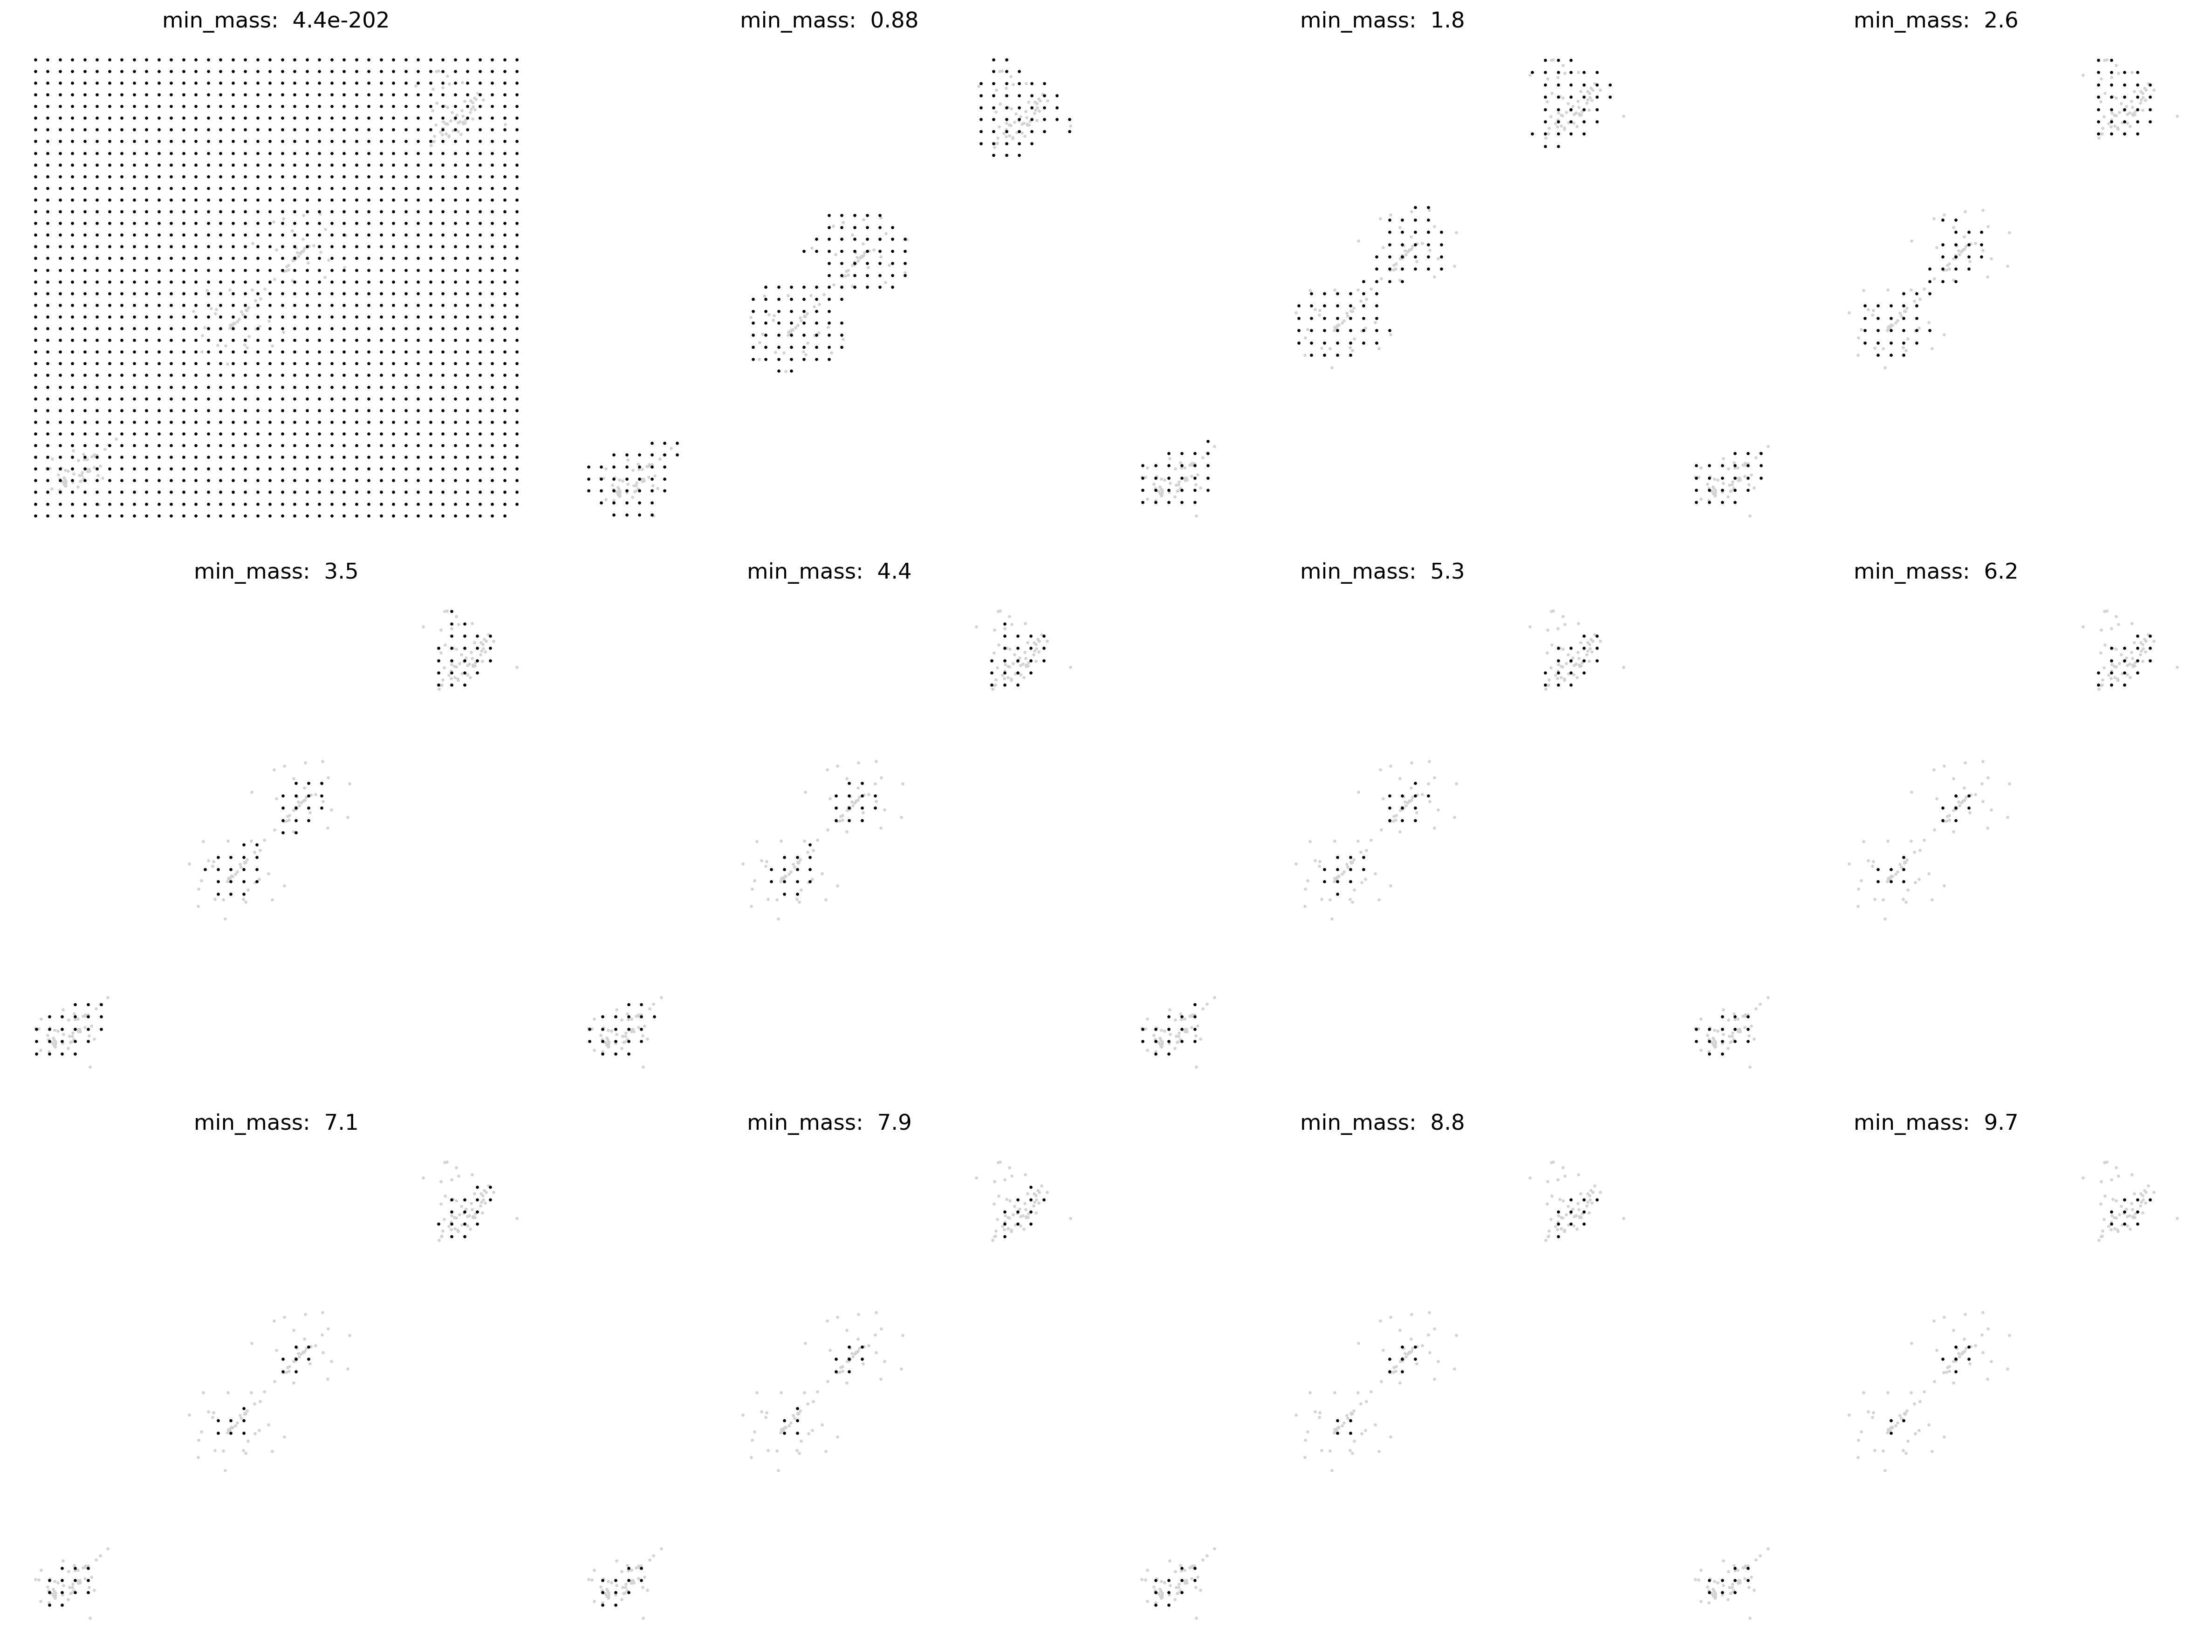

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


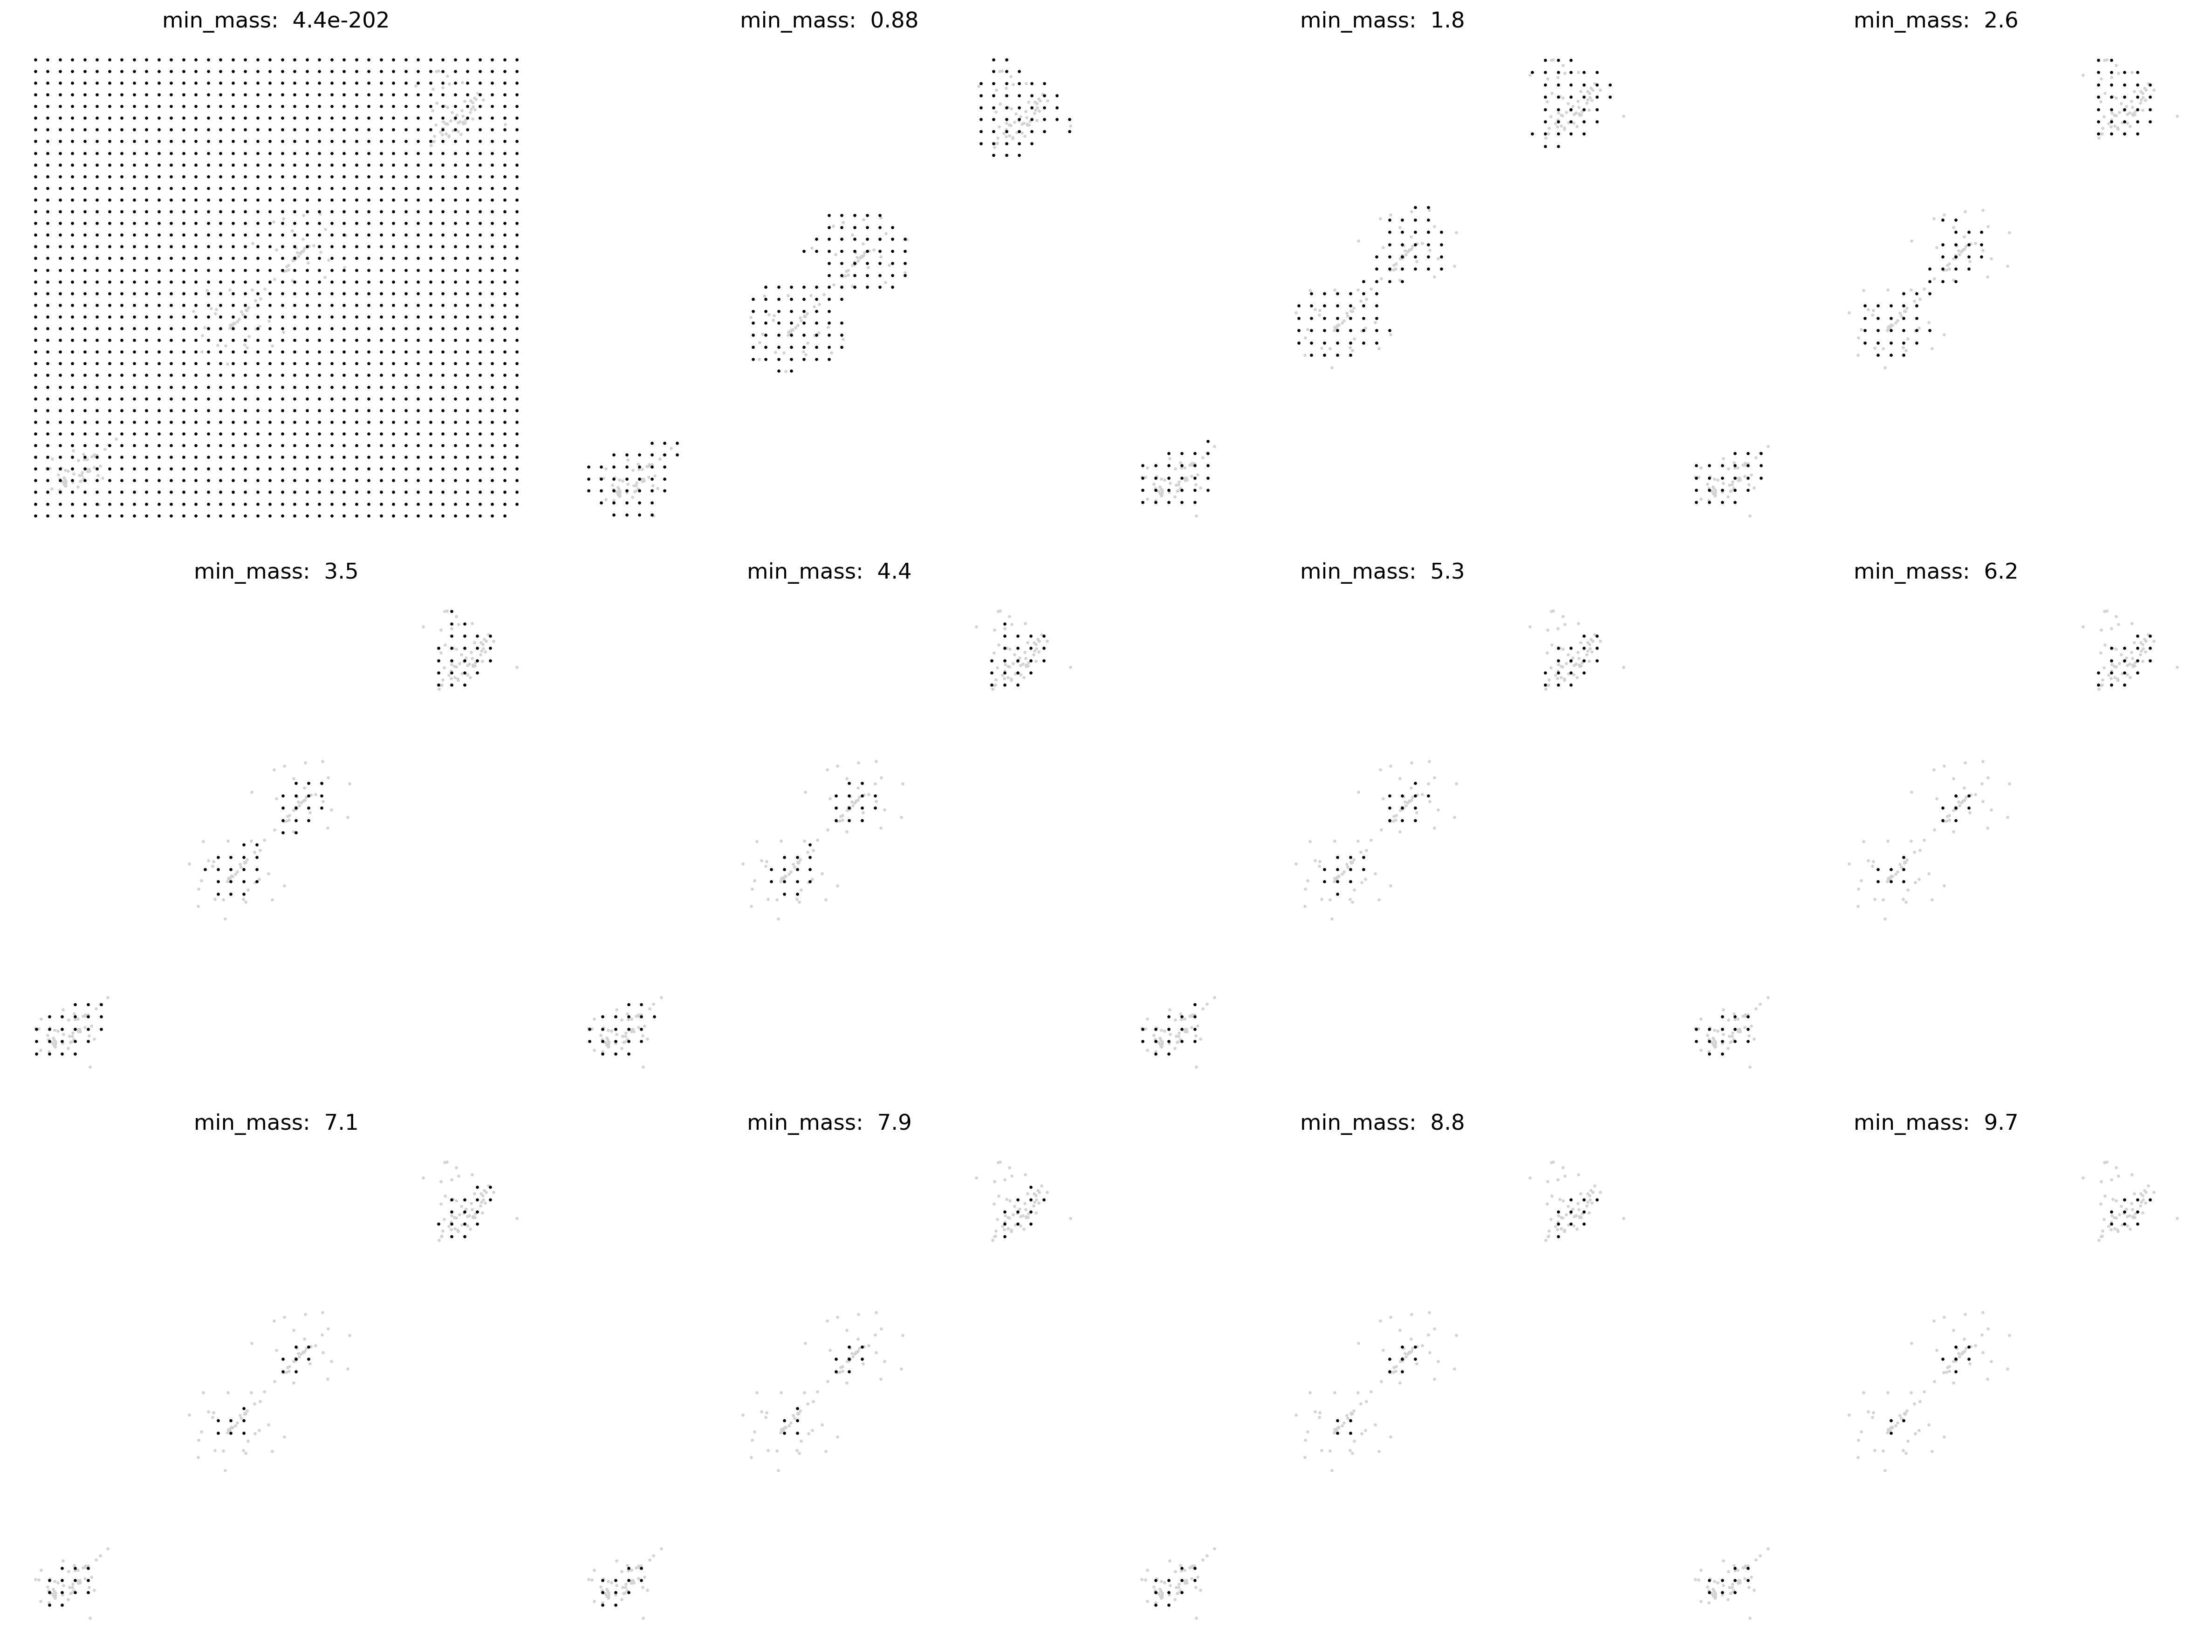

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


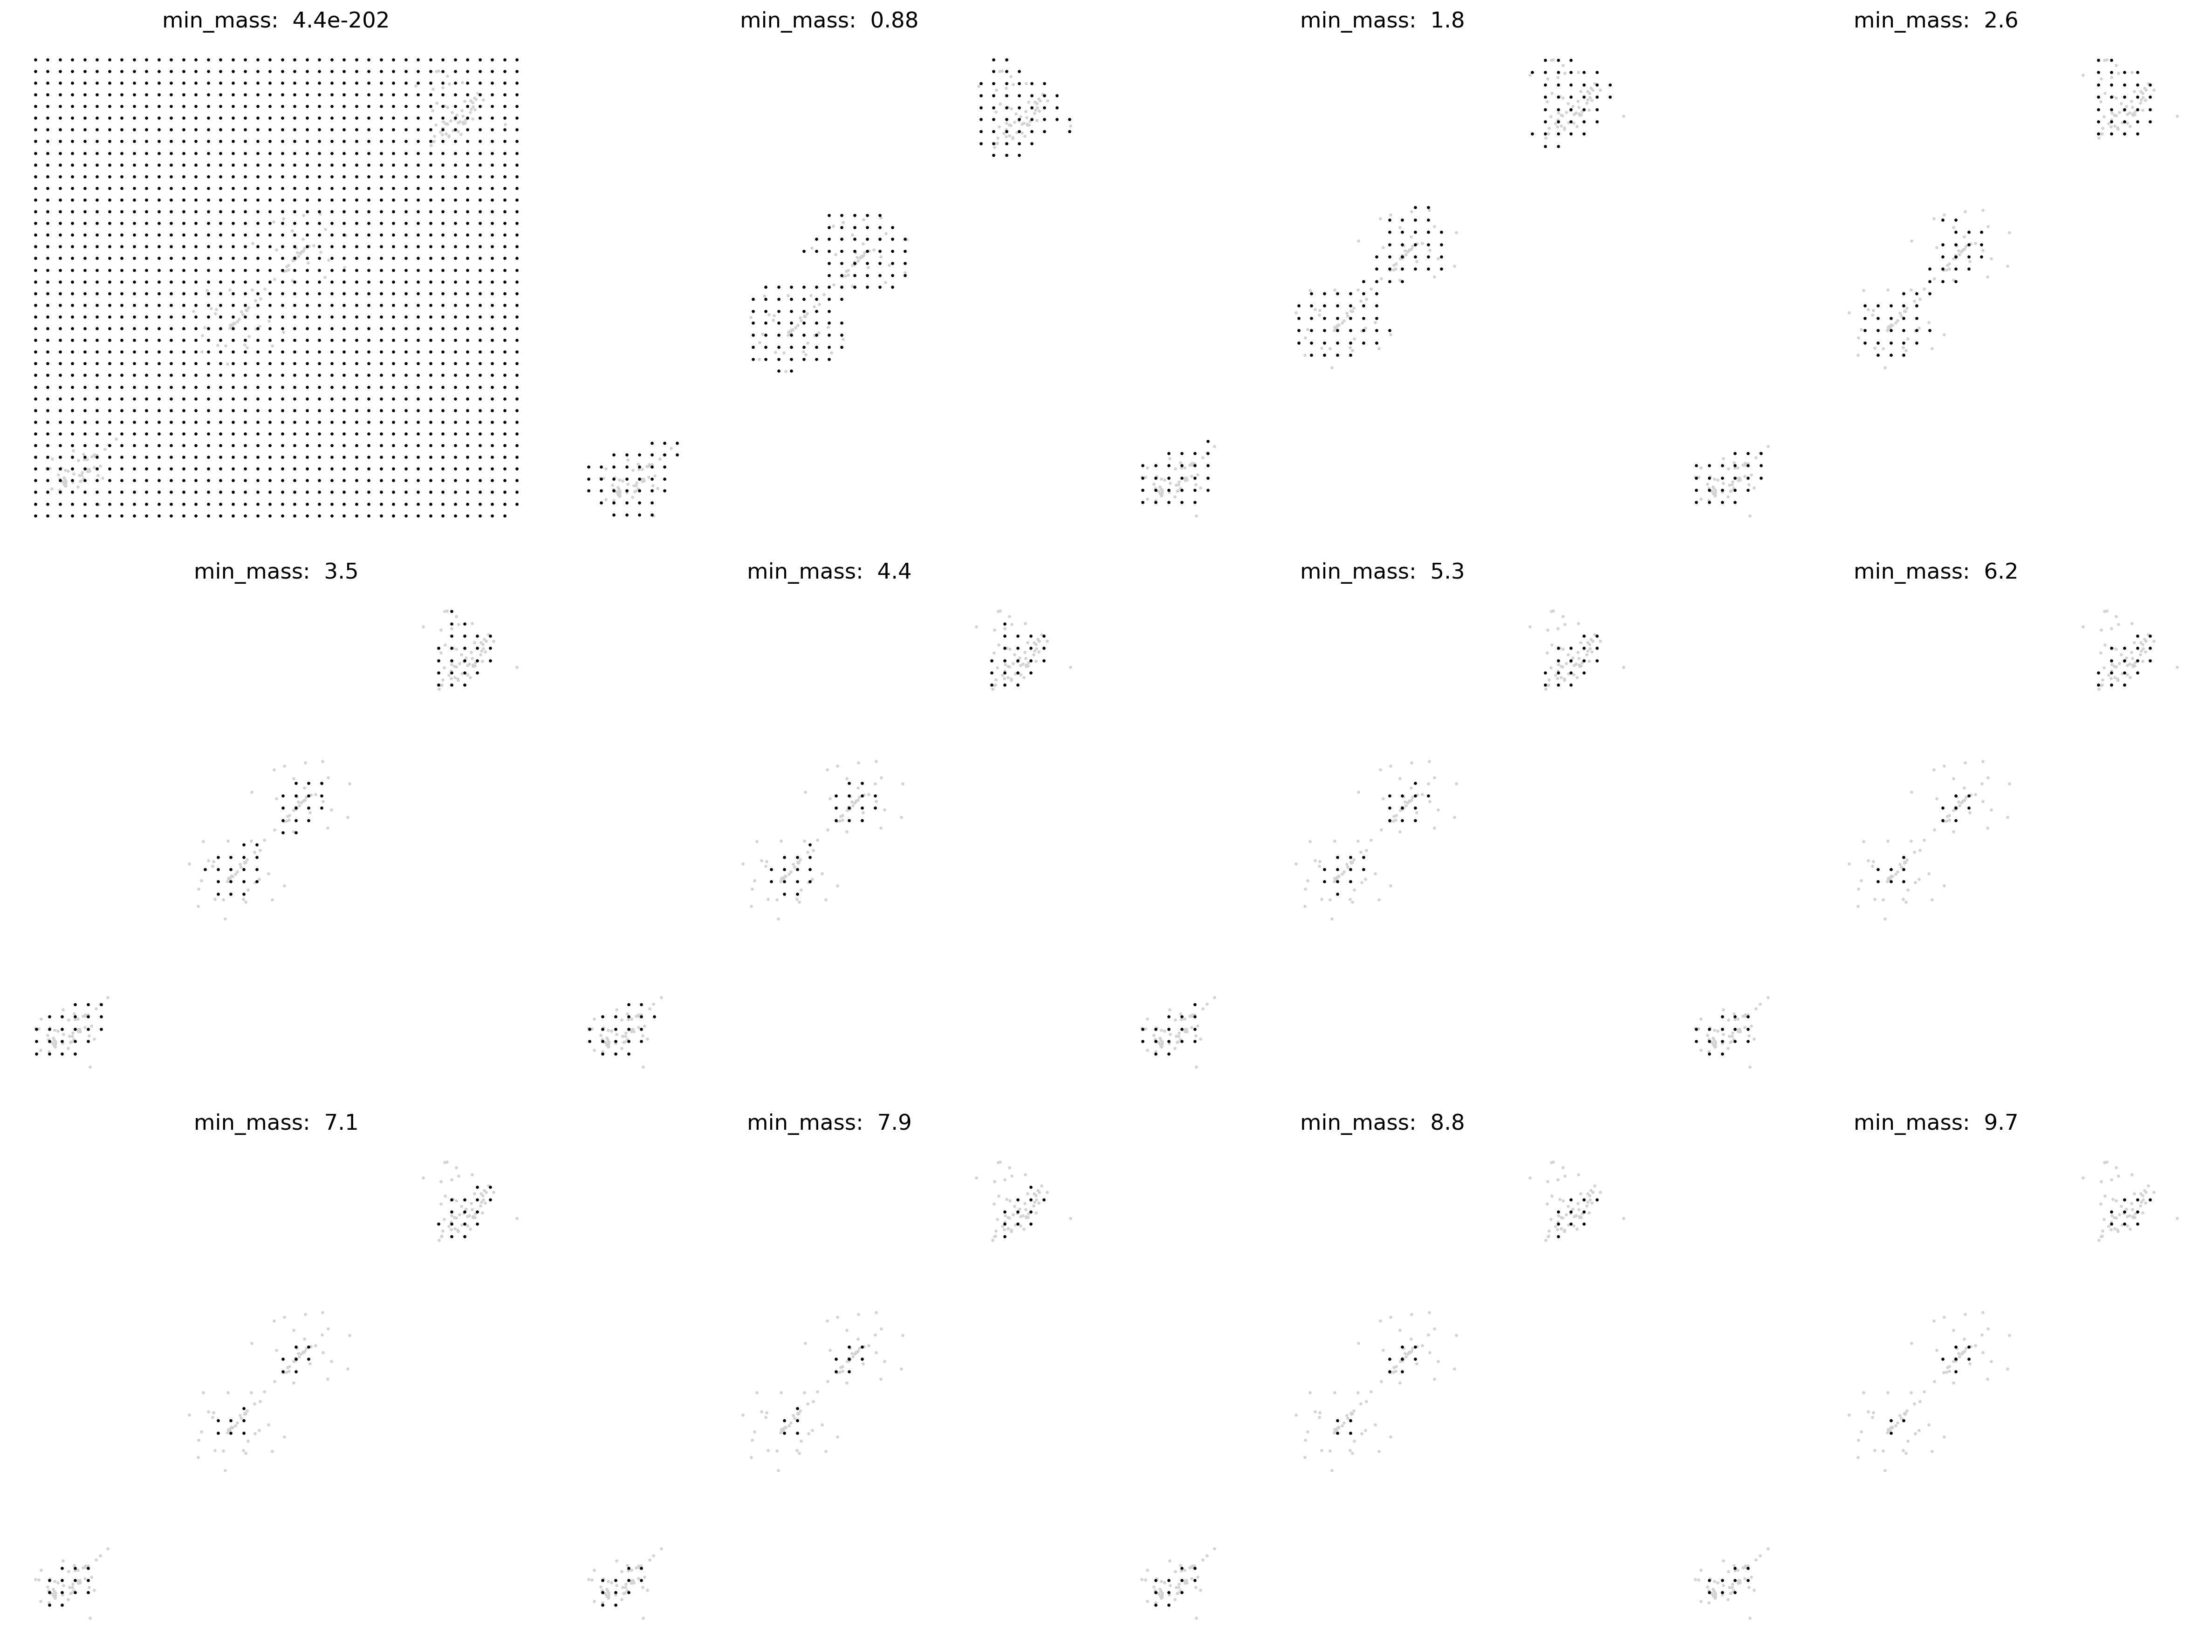

KeyError: 'mass_filter'

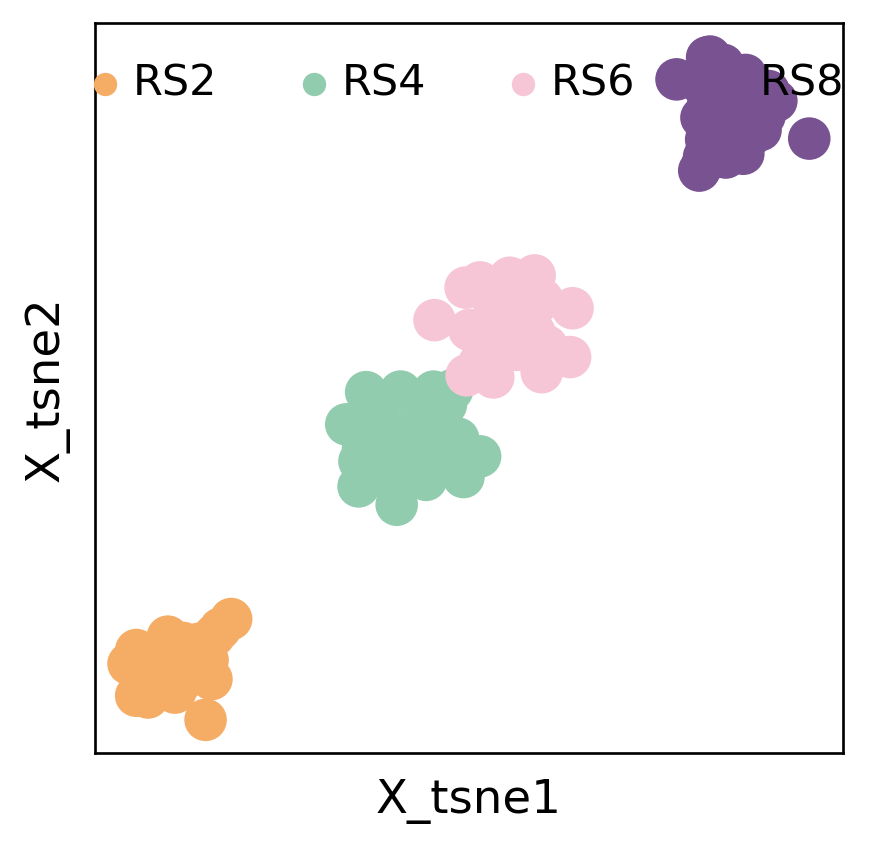

In [196]:
KO_Genes_246=[['Tbpl1'],['Tbpl1'],['Tbpl1']]
adata_collect_246 = pert_plot_all_in_one_down(adata_all_TF, adata_all_down, models, state_pairs=[('RS2','RS4'), ('RS4','RS6'), ('RS6','RS8')],
                                         KO_Genes=KO_Genes_246, draw_singles=['RS2', 'RS4', 'RS6'], scale=6, min_mass=1,save_dir=output_path,run_suggest_mass_thresholds=True)

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


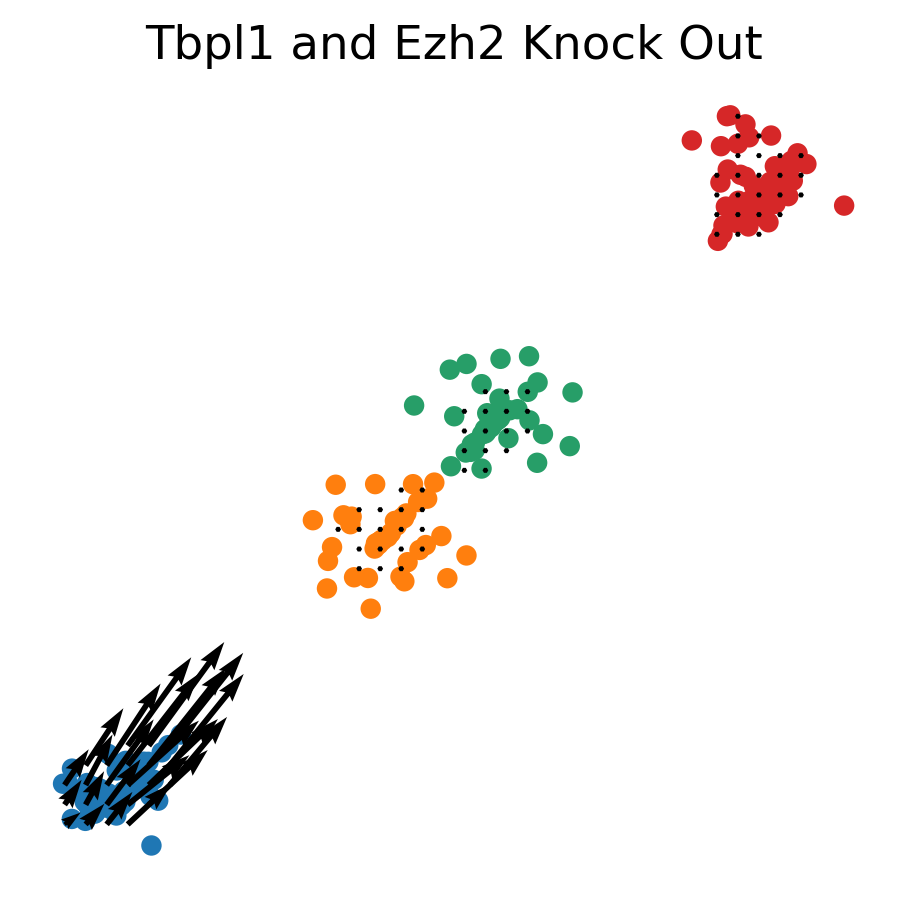

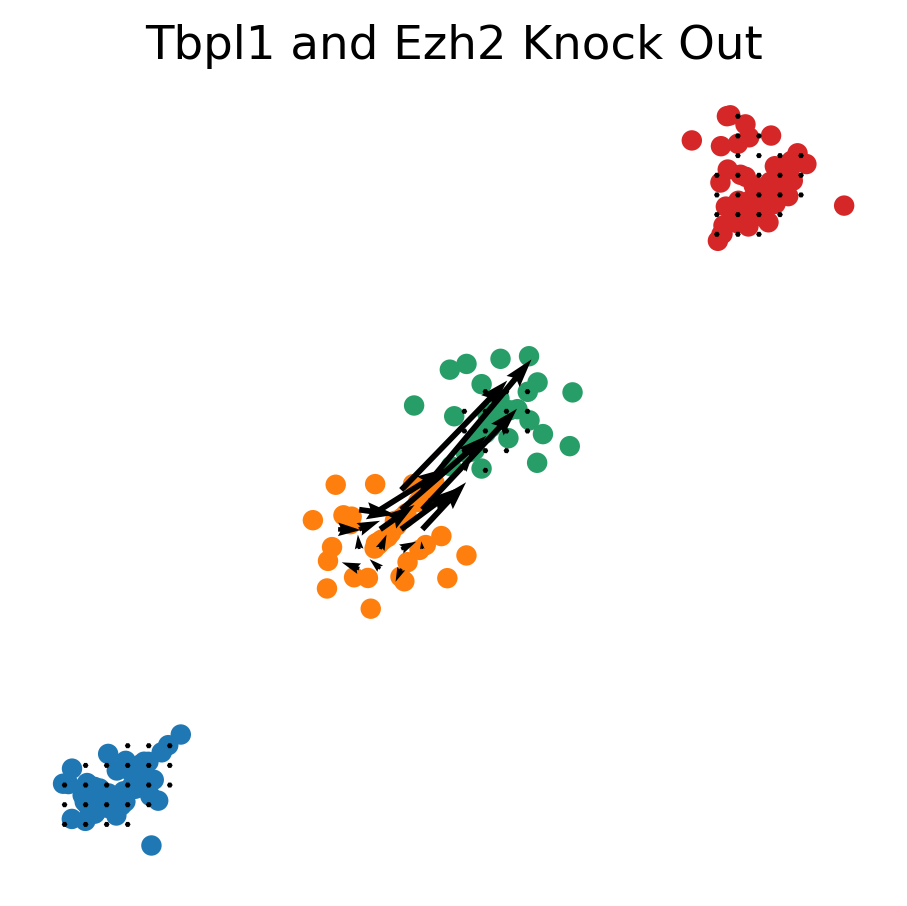

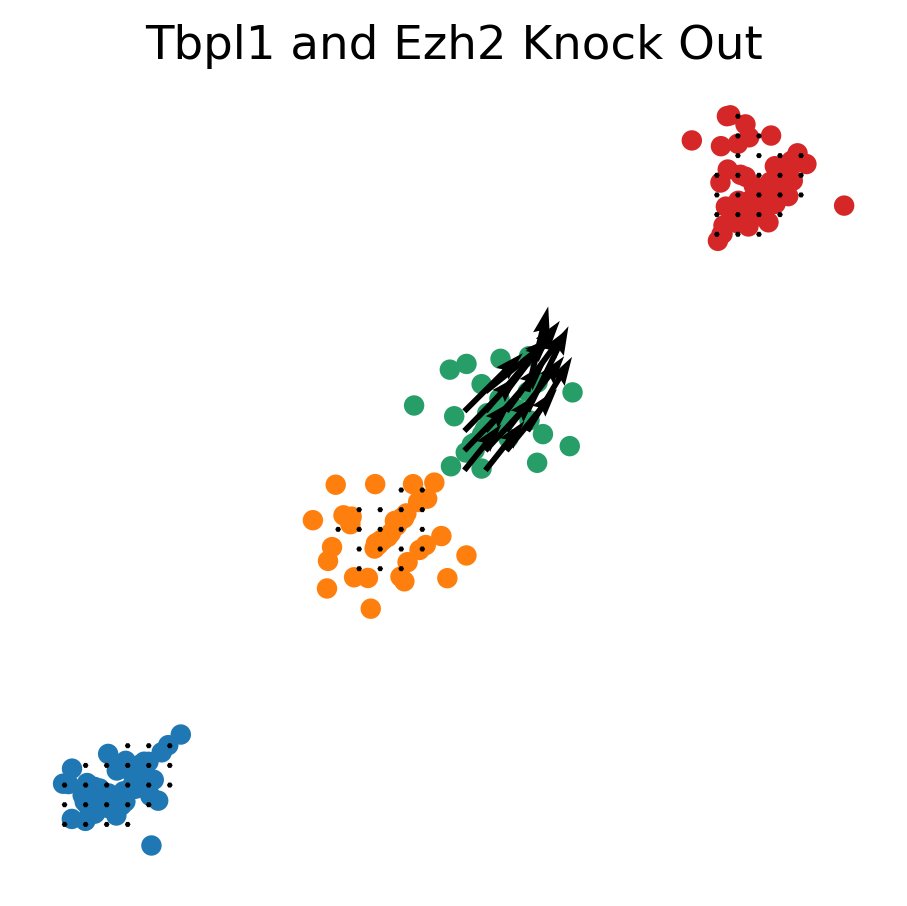

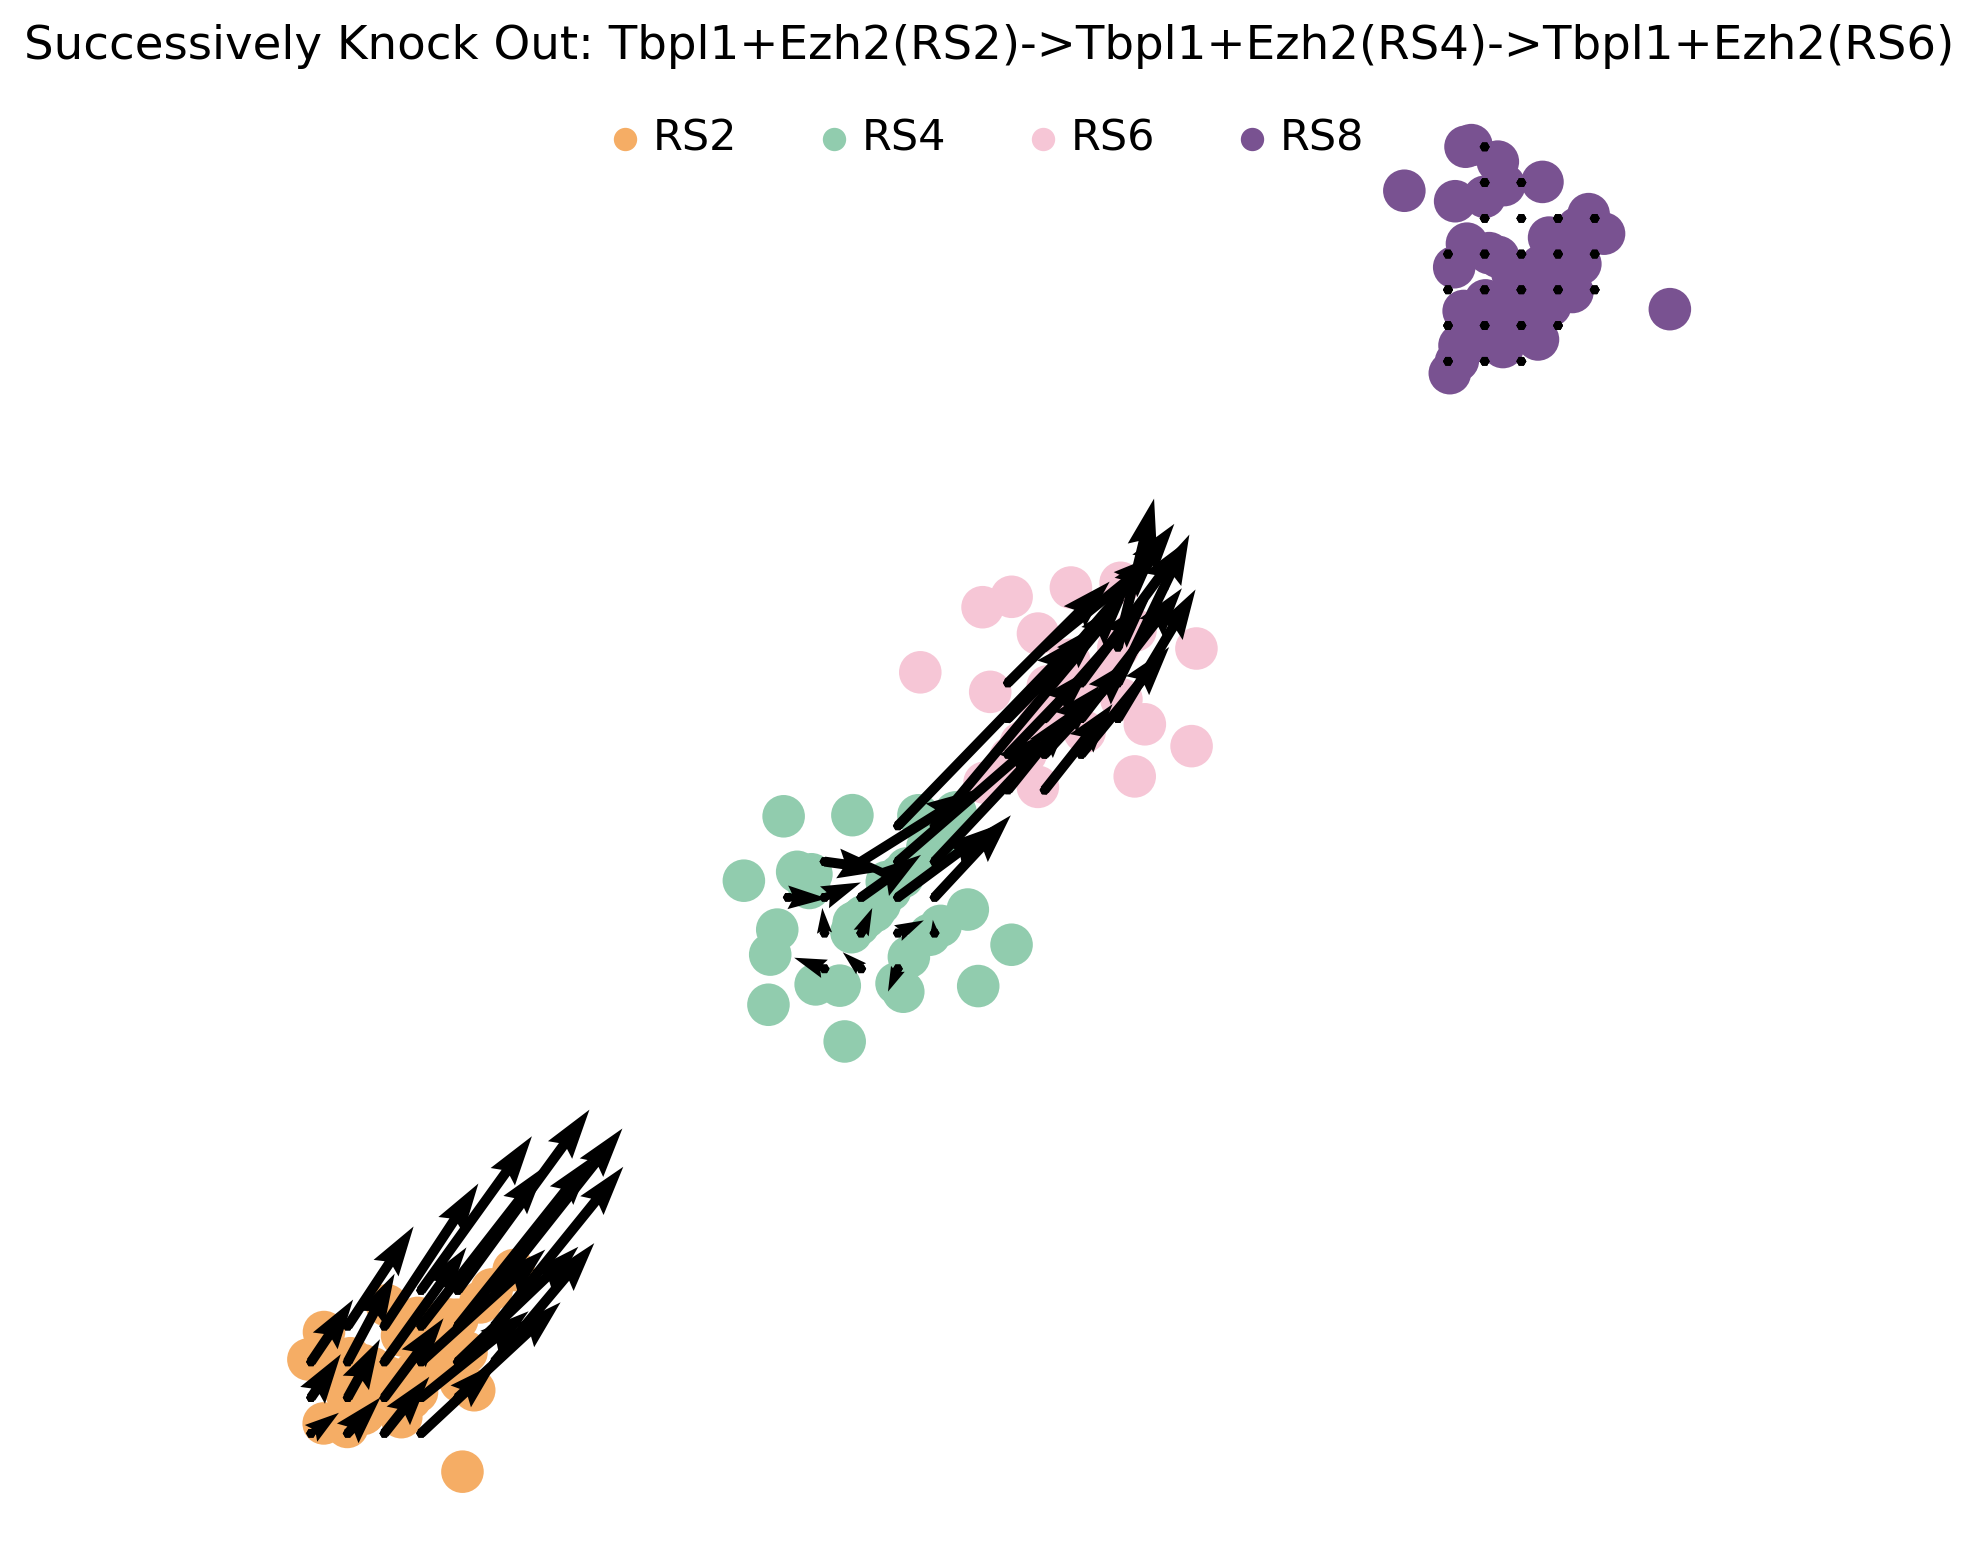

In [301]:
KO_Genes_246=[['Tbpl1','Ezh2'],['Tbpl1','Ezh2'],['Tbpl1','Ezh2']]
adata_collect_246 = pert_plot_all_in_one_down(adata_all_TF, adata_all_down, models, state_pairs=[('RS2','RS4'), ('RS4','RS6'), ('RS6','RS8')],
                                         KO_Genes=KO_Genes_246, draw_singles=['RS2', 'RS4', 'RS6'], scale=6, min_mass=3.5,save_dir=output_path,
                                              run_suggest_mass_thresholds=False,method=None,n_neighbors=None, dot_size=150)

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


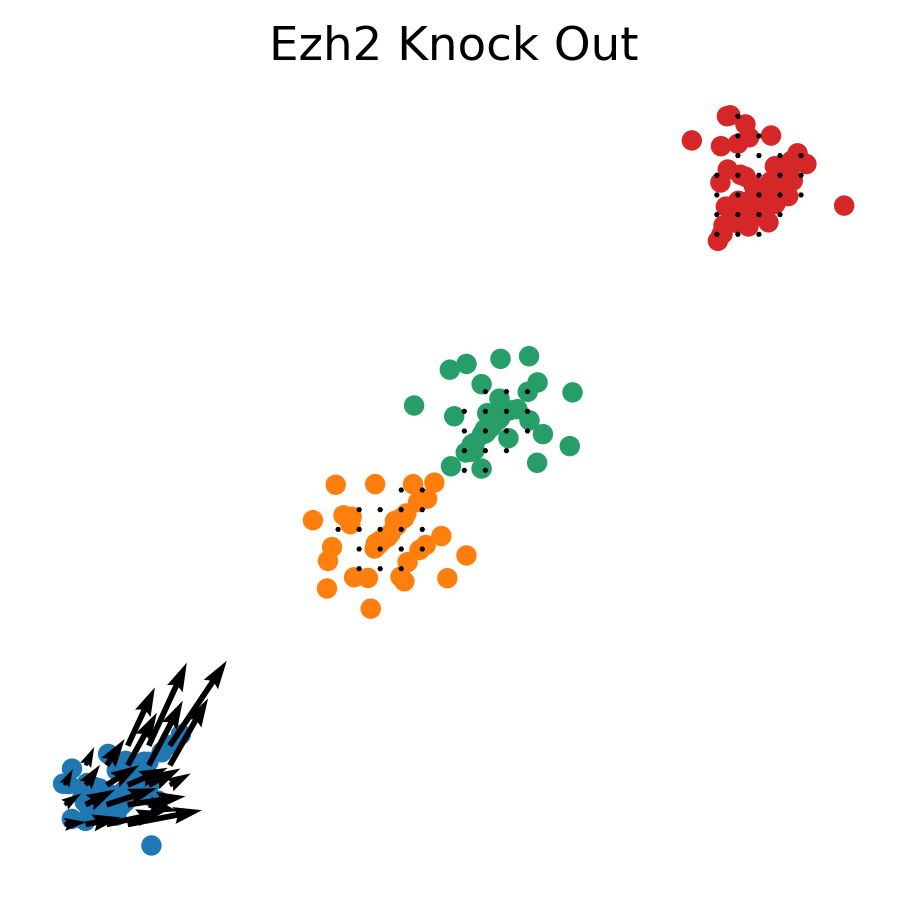

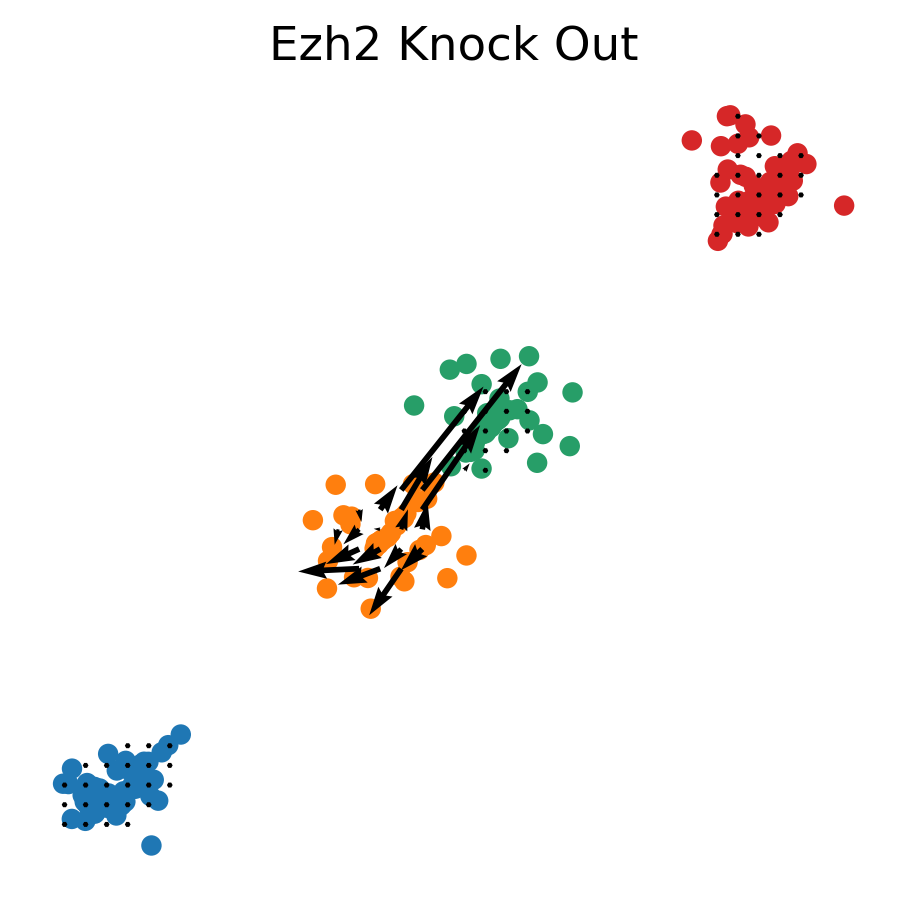

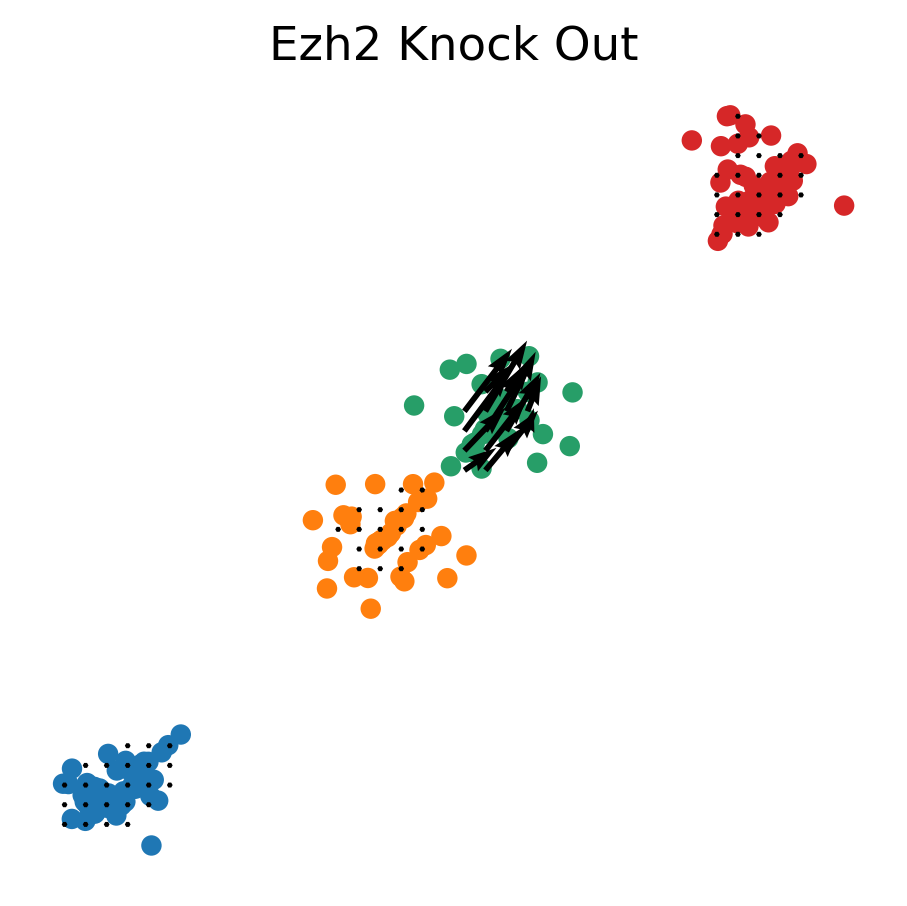

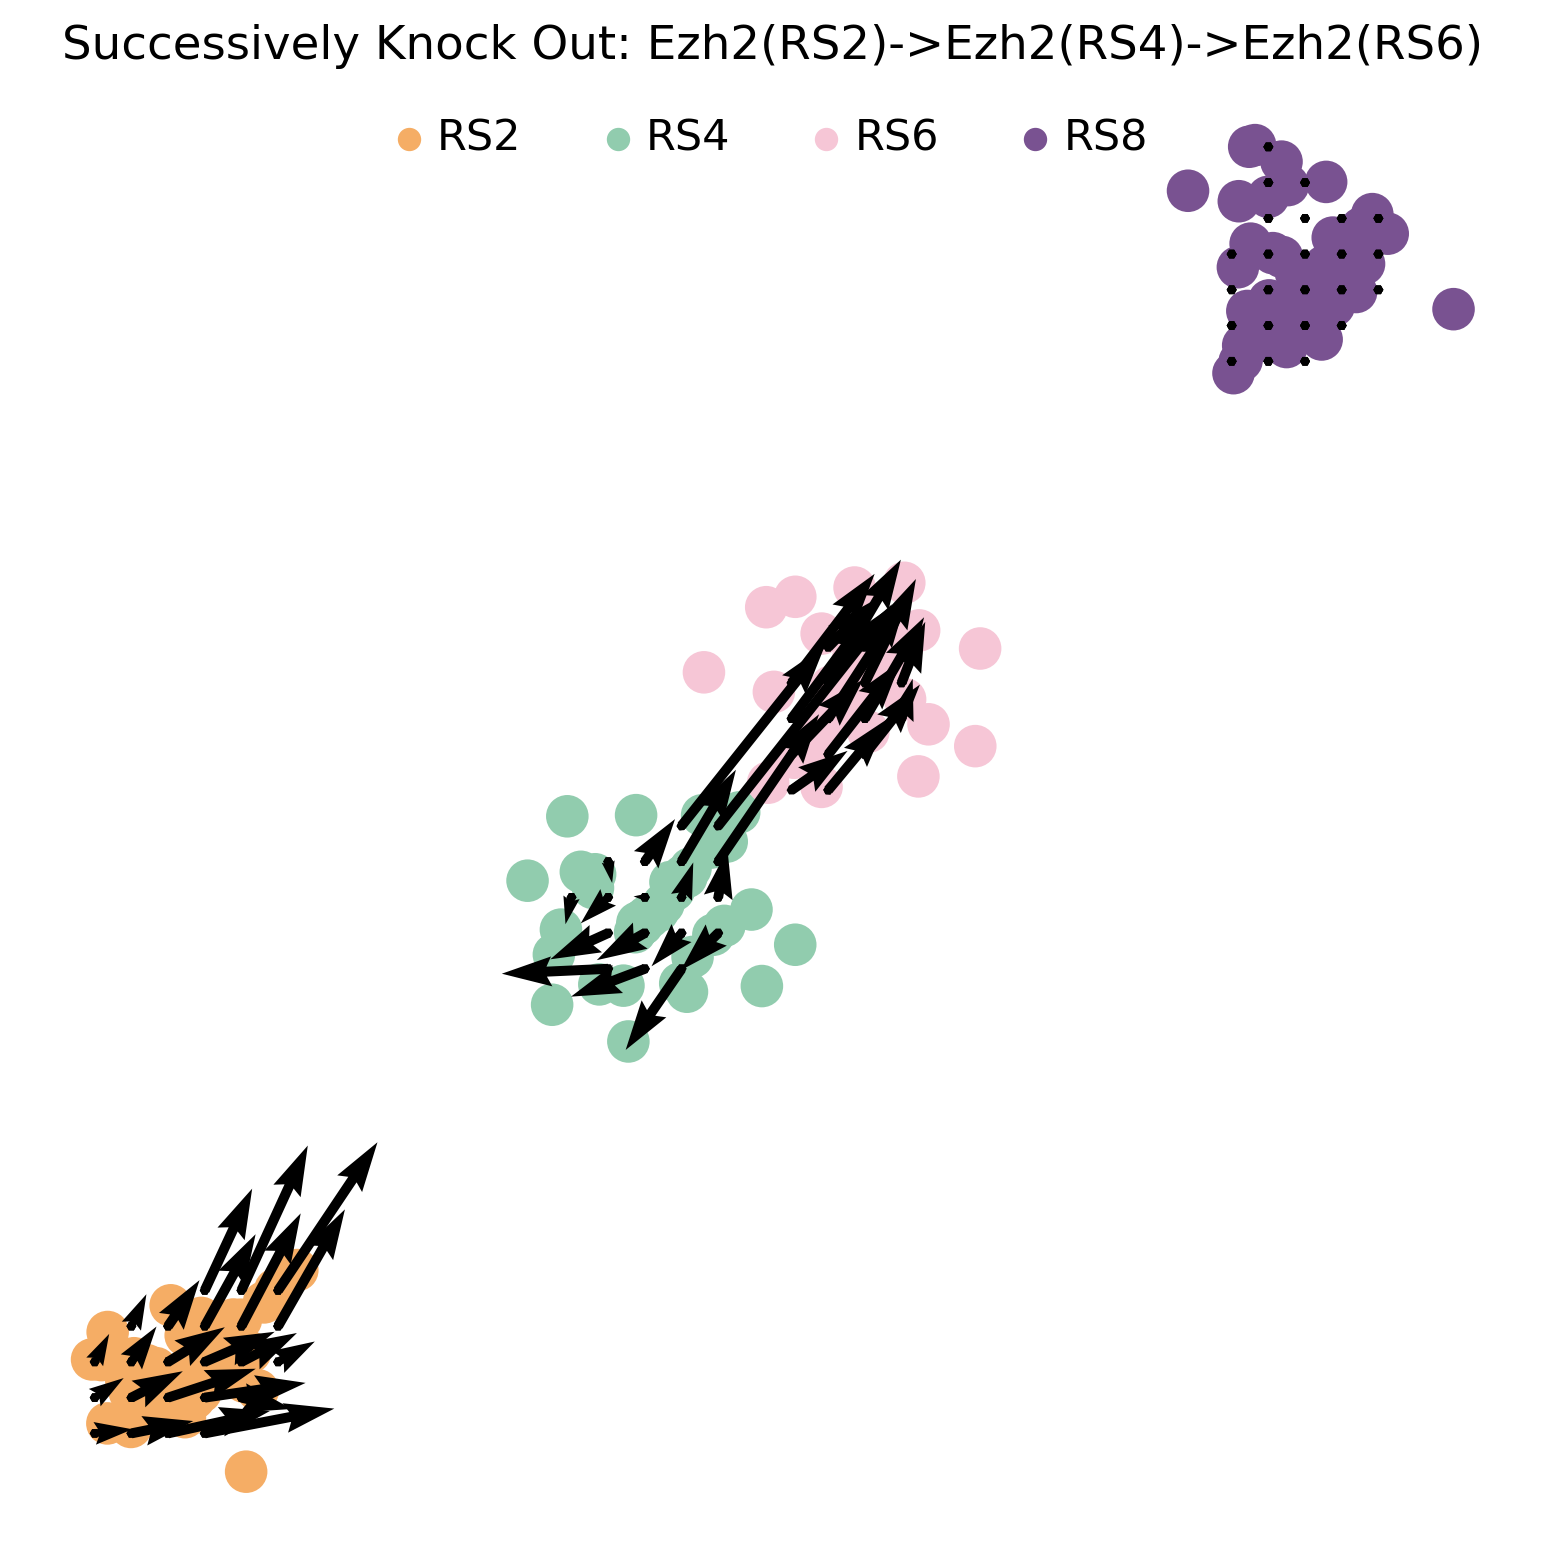

In [302]:
KO_Genes_246=[['Ezh2'],['Ezh2'],['Ezh2']]
adata_collect_246 = pert_plot_all_in_one_down(adata_all_TF, adata_all_down, models, state_pairs=[('RS2','RS4'), ('RS4','RS6'), ('RS6','RS8')],
                                         KO_Genes=KO_Genes_246, draw_singles=['RS2', 'RS4', 'RS6'], scale=6, min_mass=3.5,save_dir=output_path,
                                              run_suggest_mass_thresholds=False,method=None,n_neighbors=None, dot_size=150)

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


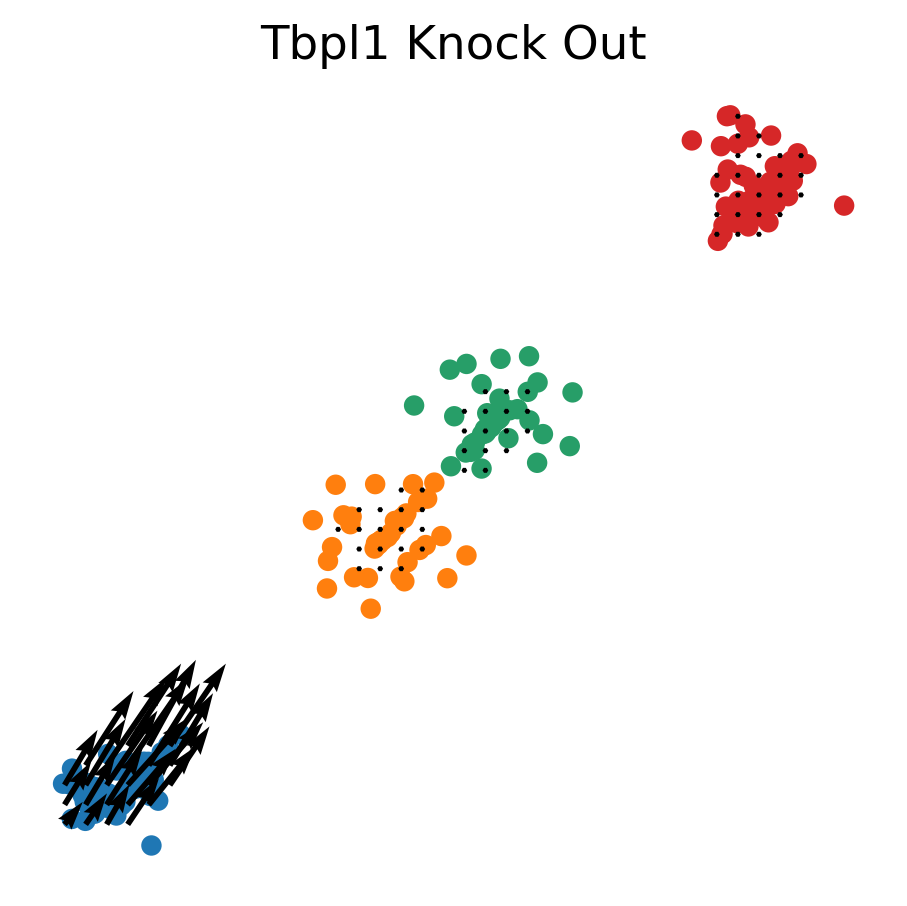

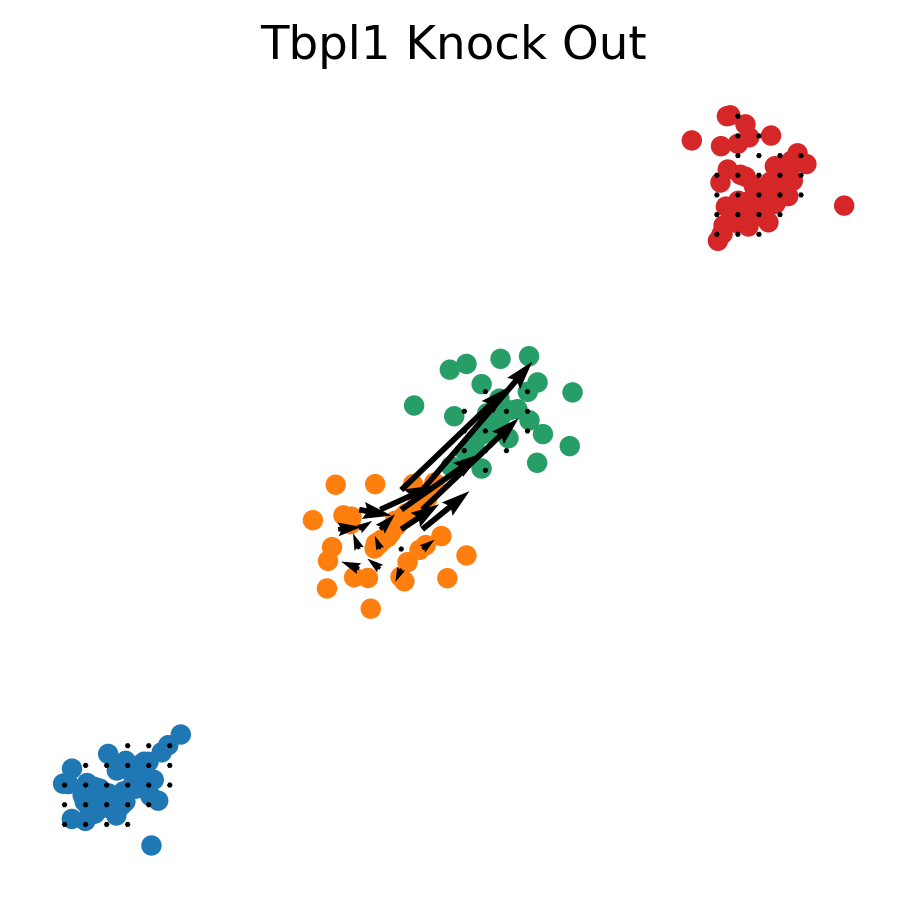

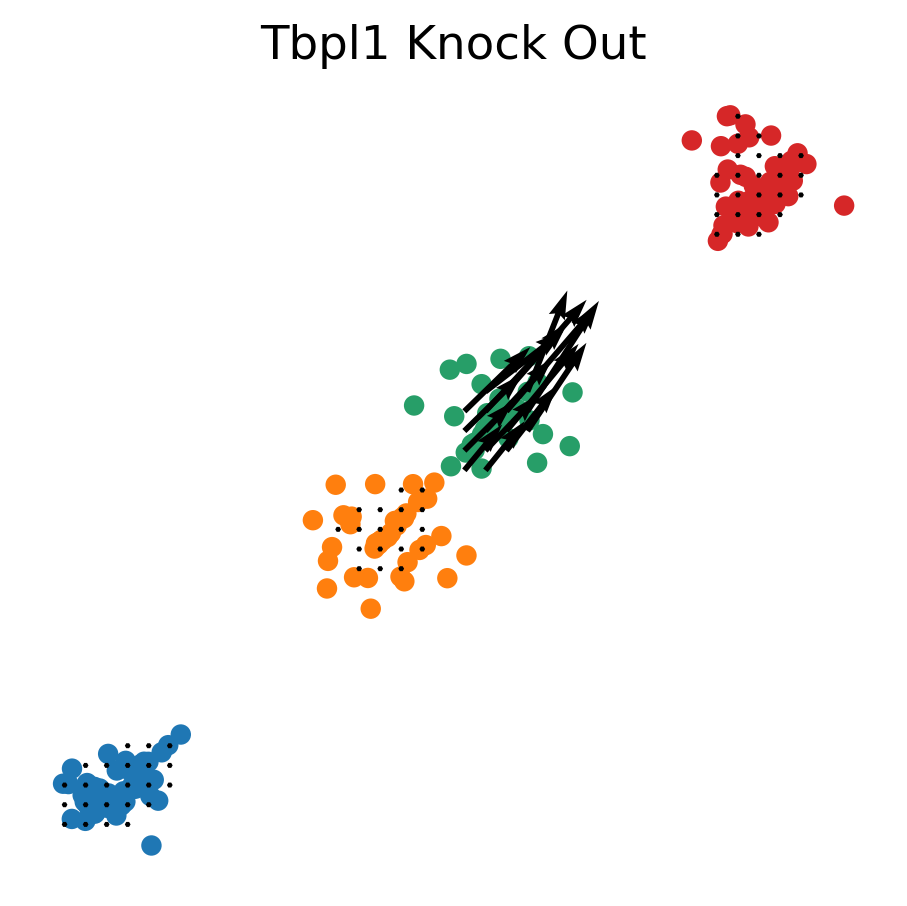

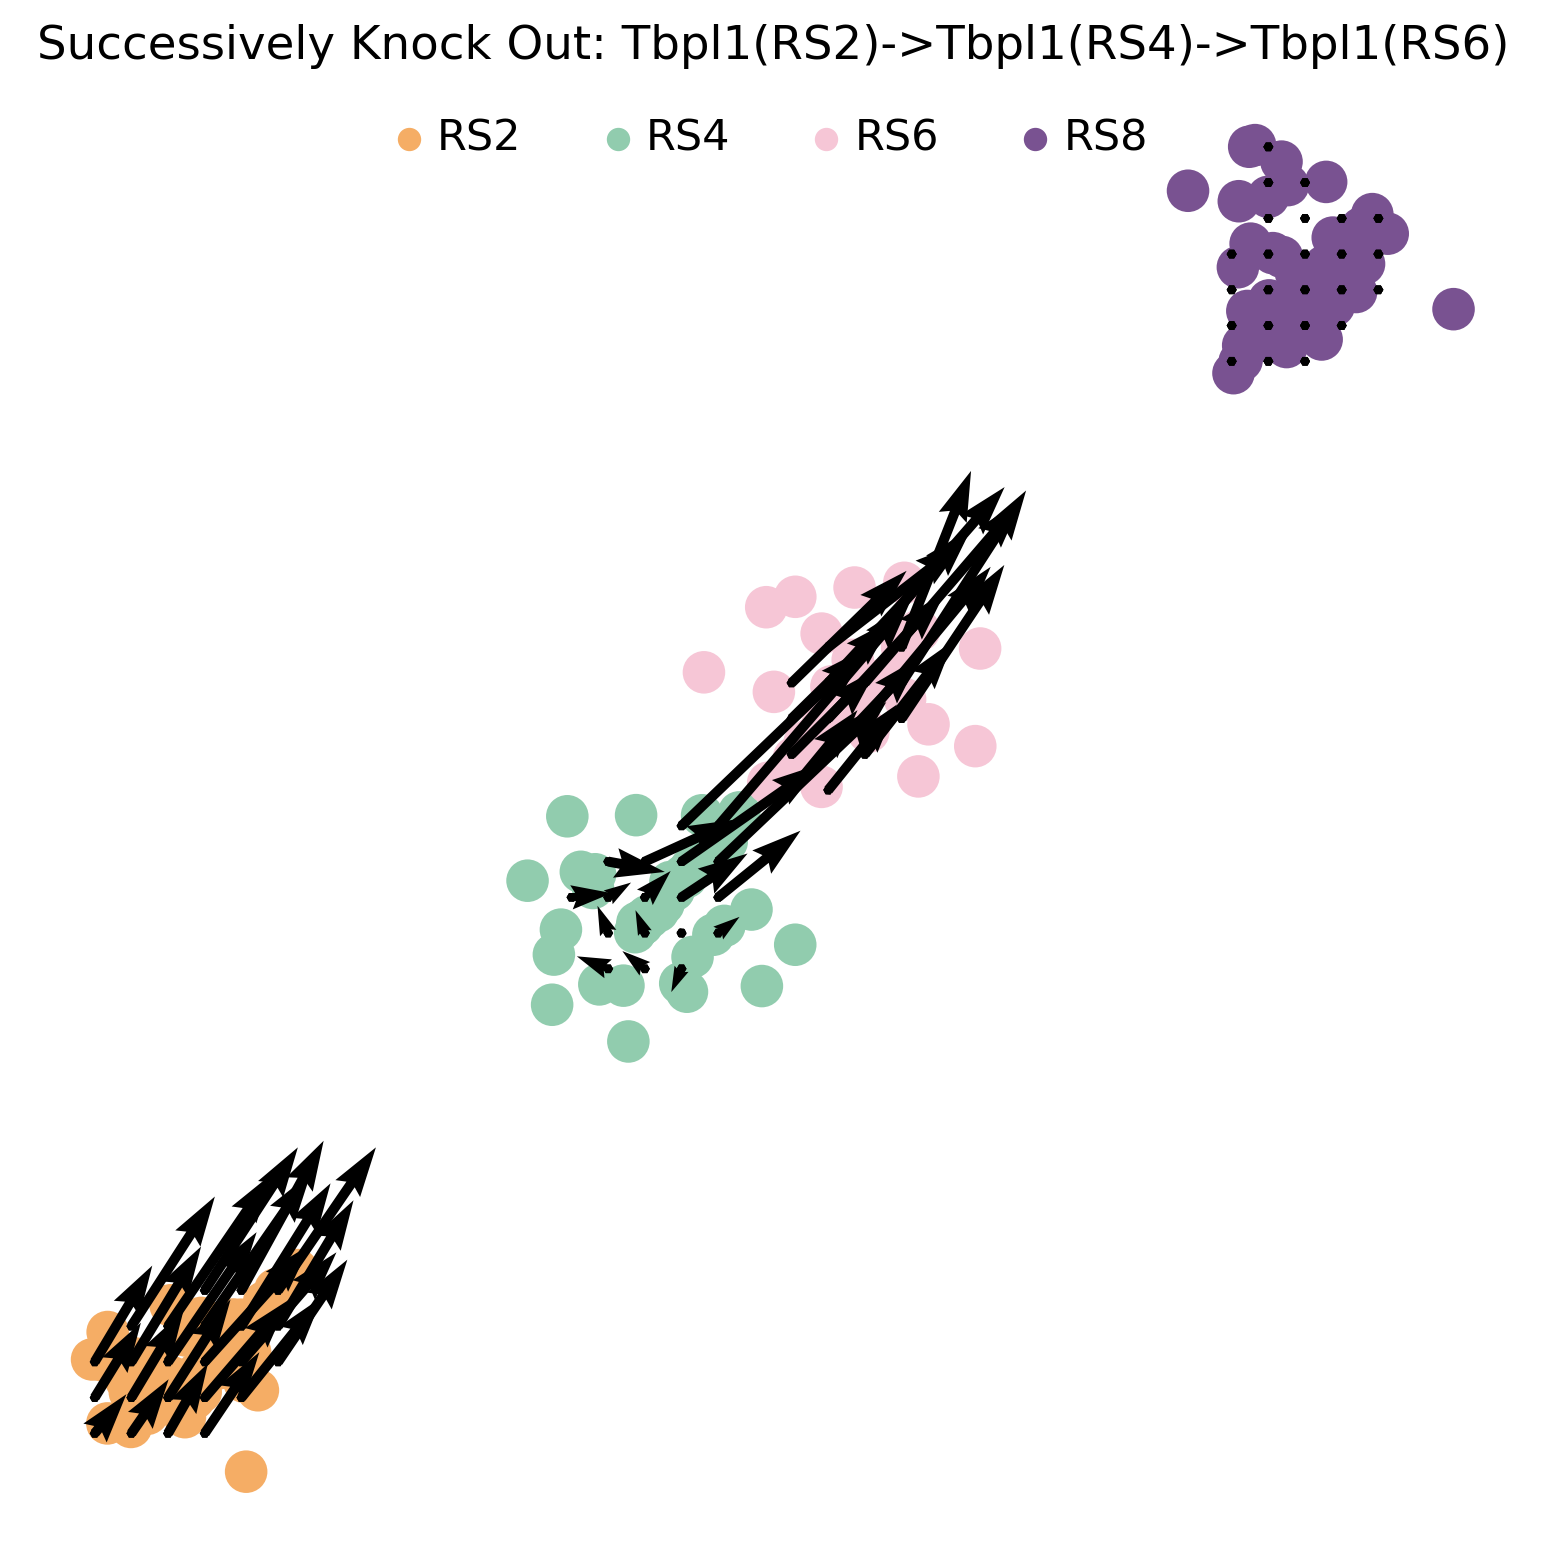

In [303]:
KO_Genes_246=[['Tbpl1'],['Tbpl1'],['Tbpl1']]
adata_collect_246 = pert_plot_all_in_one_down(adata_all_TF, adata_all_down, models, state_pairs=[('RS2','RS4'), ('RS4','RS6'), ('RS6','RS8')],
                                         KO_Genes=KO_Genes_246, draw_singles=['RS2', 'RS4', 'RS6'], scale=6, min_mass=3.5,save_dir=output_path,
                                              run_suggest_mass_thresholds=False,method=None,n_neighbors=None, dot_size=150)